# Estimating major event impact on German electricity prices
Notebook 02 EDA
___

## Table of Contents:
* [Introduction](#heading-1)
* [EDA](#heading-2)
    * [Price adjustment with inflation data](#sub-heading-1)
    * [Price adjustment with co2-prices](#sub-heading-2)
    * [Generation and Consumption](#sub-heading-3)
* [Export](#heading-3)

## Introduction <a class="anchor" id="heading-1"></a>

After the raw data had already been searched for missing values and cleaned up in the previous [Notebook-01 data-loading-cleaning](01-data-loading-cleaning.ipynb), the first insights are now being gained in this Notebook as part of an EDA.

In addition, we introduce here the two events of interest whose influence on the electricity price we want to quantify. These are:
- the Russian-Ukrainian war starting on February 24, 2024
- the interruption of gas supplies from June 14, 2022


### Import libraries 

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from statsmodels.tsa.seasonal import seasonal_decompose 
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import month_plot

plt.rcParams.update({'font.size': 13})

### Definition of functions

The following functions are used in this notebook. 

In [2]:
def data_loading_and_set_index(df_name, base_path = '../data/'):
    '''
    loads the dataframe df from the base_path and set_the 'Start' column as the index in datetime format.

    df_name: expect a df Name for example Prices_FRA_hourly
    base_path default: '../data/' 

    return Prices_FRA_hourly
    '''
    
    file_path = f"{base_path}{df_name}.csv"
    df= pd.read_csv(file_path)
    
    df['Start'] = pd.to_datetime(df['Unnamed: 0'])
    df = df.drop(columns = 'Unnamed: 0')
    df = df.set_index('Start')

    return df

In [3]:

def decomposition_df(df, column, frequency='MS',aggregation_method='sum', type='additive'):
    '''
    Process a dataframe to decompose its time series data and add trend, seasonal, residual, and trend+seasonal columns.
    
    Parameters:
    - df: pandas DataFrame containing the data to be processed
    - column: the column to be processed in the dataframe
    - frequency: the frequency of the decomposition, default monthly 
        - D - daily
        - h- hourly
        - W- weekly 

        look here: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects
    -aggregation_method: the method of the decomposition, default sum
        -mean
        -min
        -max


    -type: the used model in the decomposition, default = additive
        - multiplicative 
    
    
    Returns:
    - df_Frequency: the processed DataFrame with additional columns
    '''
    aggregation_func = getattr(pd.DataFrame, aggregation_method)
    df_Frequency=df[[column]].resample(frequency).apply(aggregation_func)
    decompositon= seasonal_decompose(df_Frequency[column], model=type)


    df_Frequency['Trend'] = decompositon.trend
    df_Frequency['Seasonal'] = decompositon.seasonal
    df_Frequency['Residual'] = decompositon.resid
    df_Frequency['Trend+Seasonal'] = df_Frequency['Seasonal'] + df_Frequency['Trend']

    return df_Frequency


In [4]:
def date_feature_creator(df):
    '''
    Create features out of the time series datetime index of a dataframe df 
    '''
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.day_of_week #Monday = 0, Sunday = 6
    df['dayofyear'] = df.index.day_of_year #o to 365
    df['month'] = df.index.month
    df['year'] = df.index.year
    return df

### Loading of the cleaned notebooks from the previous data loading and cleaning process

In [5]:
Consumption = data_loading_and_set_index('Consumption')
Generation = data_loading_and_set_index('Generation')
Export_Import = data_loading_and_set_index('Export_Import')
Prices = data_loading_and_set_index('Prices')
Inflation_index = data_loading_and_set_index('Inflation_index')

In [6]:
co2_Prices = pd.read_csv('../data/co2_Prices.csv')
co2_Prices['Date'] = pd.to_datetime(co2_Prices['Date'])
co2_Prices = co2_Prices.set_index('Date')

We create a mirrored twin of the Export_Import dataframe to consider this as part of the generation, so Import must be a positive value and Export a negative value. 

In [7]:
Import_Export = Export_Import*-1

Import_Export.rename(columns={'Export_Import_sum':'Import_Export_sum'}, inplace=True)
Generation = pd.concat([Generation,Import_Export], axis=1)

We create a new total for the entire generation

In [8]:
Generation['Total_sum'] = Generation['Generation_sum']+Generation['Import_Export_sum']

The electricity price data now has the following columns. 

| Generation           |       | Consumption          |       | Prices             |         | Export_Import (+/-)**    |       |
|----------------------|-------|----------------------|-------|--------------------|---------|-----------------|-------|
|                      |       |                      |       |                    |         |                 |       |
| Column               | Unit  | Column               | Unit  | Column             | Unit    | Column         | Unit  |
| Biomass              | [MWh] | Total_sum                | [MWh] | Germany_Luxembourg | [€/MWh] | Export_Import_sum             | [MWh] |
| Hydropower           | [MWh] | Residual             | [MWh] | Belgium            | [€/MWh] | Belgium_sum     | [MWh] |
| Wind_offshore        | [MWh] | Hydro_pumped_storage | [MWh] | France             | [€/MWh] | France_sum      | [MWh] |
| Wind_onshore         | [MWh] |                      |       | Austria             | [€/MWh] | Poland_sum      | [MWh] |
| Photovoltaics        | [MWh] |                      |       | Switzerland            | [€/MWh] | Austrian_sum    | [MWh] |
| Other_renewable      | [MWh] |                      |       | Czech_Republic       | [€/MWh] | Switzerland_sum | [MWh] |
| Nuclear              | [MWh] |                      |       |      |  |Czech_Republic_sum| [MWh] |
| Lignite              | [MWh] |                      |       |                    |         | Export_sum                | [MWh]      |
| Hard_coal            | [MWh] |                      |       |                    |         | Import_sum                |  [MWh]     |
| Fossil_gas           | [MWh] |                      |       |                    |         | Remainder_sum                | [MWh]      |
| Hydro_pumped_storage | [MWh] |                      |       |                    |         |                 |       |
| Other_conventional   | [MWh] |                      |       |                    |         |                 |       |
| Generation_sum                  | [MWh] |                      |       |                    |         |                 |       |
| Import_Export_sum*   | [MWh] |                      |       |                    |         |                 |       |
| Export_sum   | [MWh] |                      |       |                    |         |                 |       |
| Import_sum  | [MWh] |                      |       |                    |         |                 |       |
| Belgium_sum  | [MWh] |                      |       |                    |         |                 |       |
| France_sum   | [MWh] |                      |       |                    |         |                 |       |
| Poland_sum   | [MWh] |                      |       |                    |         |                 |       |
| Austrian_sum   | [MWh] |                      |       |                    |         |                 |       |
| Chzech_Republic_sum   | [MWh] |                      |       |                    |         |                 |       |
| Switzerland_sum   | [MWh] |                      |       |                    |         |                 |       |
| Remainder_sum   | [MWh] |                      |       |                    |         |                 |       |
|   Total_sum | [MWh]  |                      |       |                    |         |                 |       |
| *Import_Export_sum   | = | Export_Import_sum x (-1)                     |       |                    |         | **Exports are positive, Imports negative       |       |
| All country sums are inverted   |  |                      |       |                    |         |                 |       |

## EDA <a class="anchor" id="heading-2"></a>

### Trend-Seasonal Decomposition

To analyse the time series, they are broken down into trend, seasonality and residuals
The GER price serves as our target variable and therefore receives special attention in the EDA. First, we plot the price and its development against the neighbouring countries to obtain an initial overview.
In order to work with clearer data, the 15 minute blocks are summarised in different time units according to visibility. 

In [9]:
Prices_FRA_weekly = decomposition_df(Prices, 'France', 'W', 'mean')
Prices_Austria_weekly = decomposition_df(Prices, 'Austria', 'W', 'mean')
Prices_Switzerland_weekly = decomposition_df(Prices, 'Switzerland', 'W', 'mean')
Prices_Belgium_weekly = decomposition_df(Prices, 'Belgium', 'W', 'mean')
Prices_Czech_Republic_weekly = decomposition_df(Prices, 'Czech_Republic', 'W', 'mean')
Prices_GER_monthly = decomposition_df(Prices, 'Germany_Luxembourg','MS','mean')


The summarisation of the time units into a frequency greater than the original is primarily for better representability. The models will later be based on an hourly basis. See notebook no. 3 

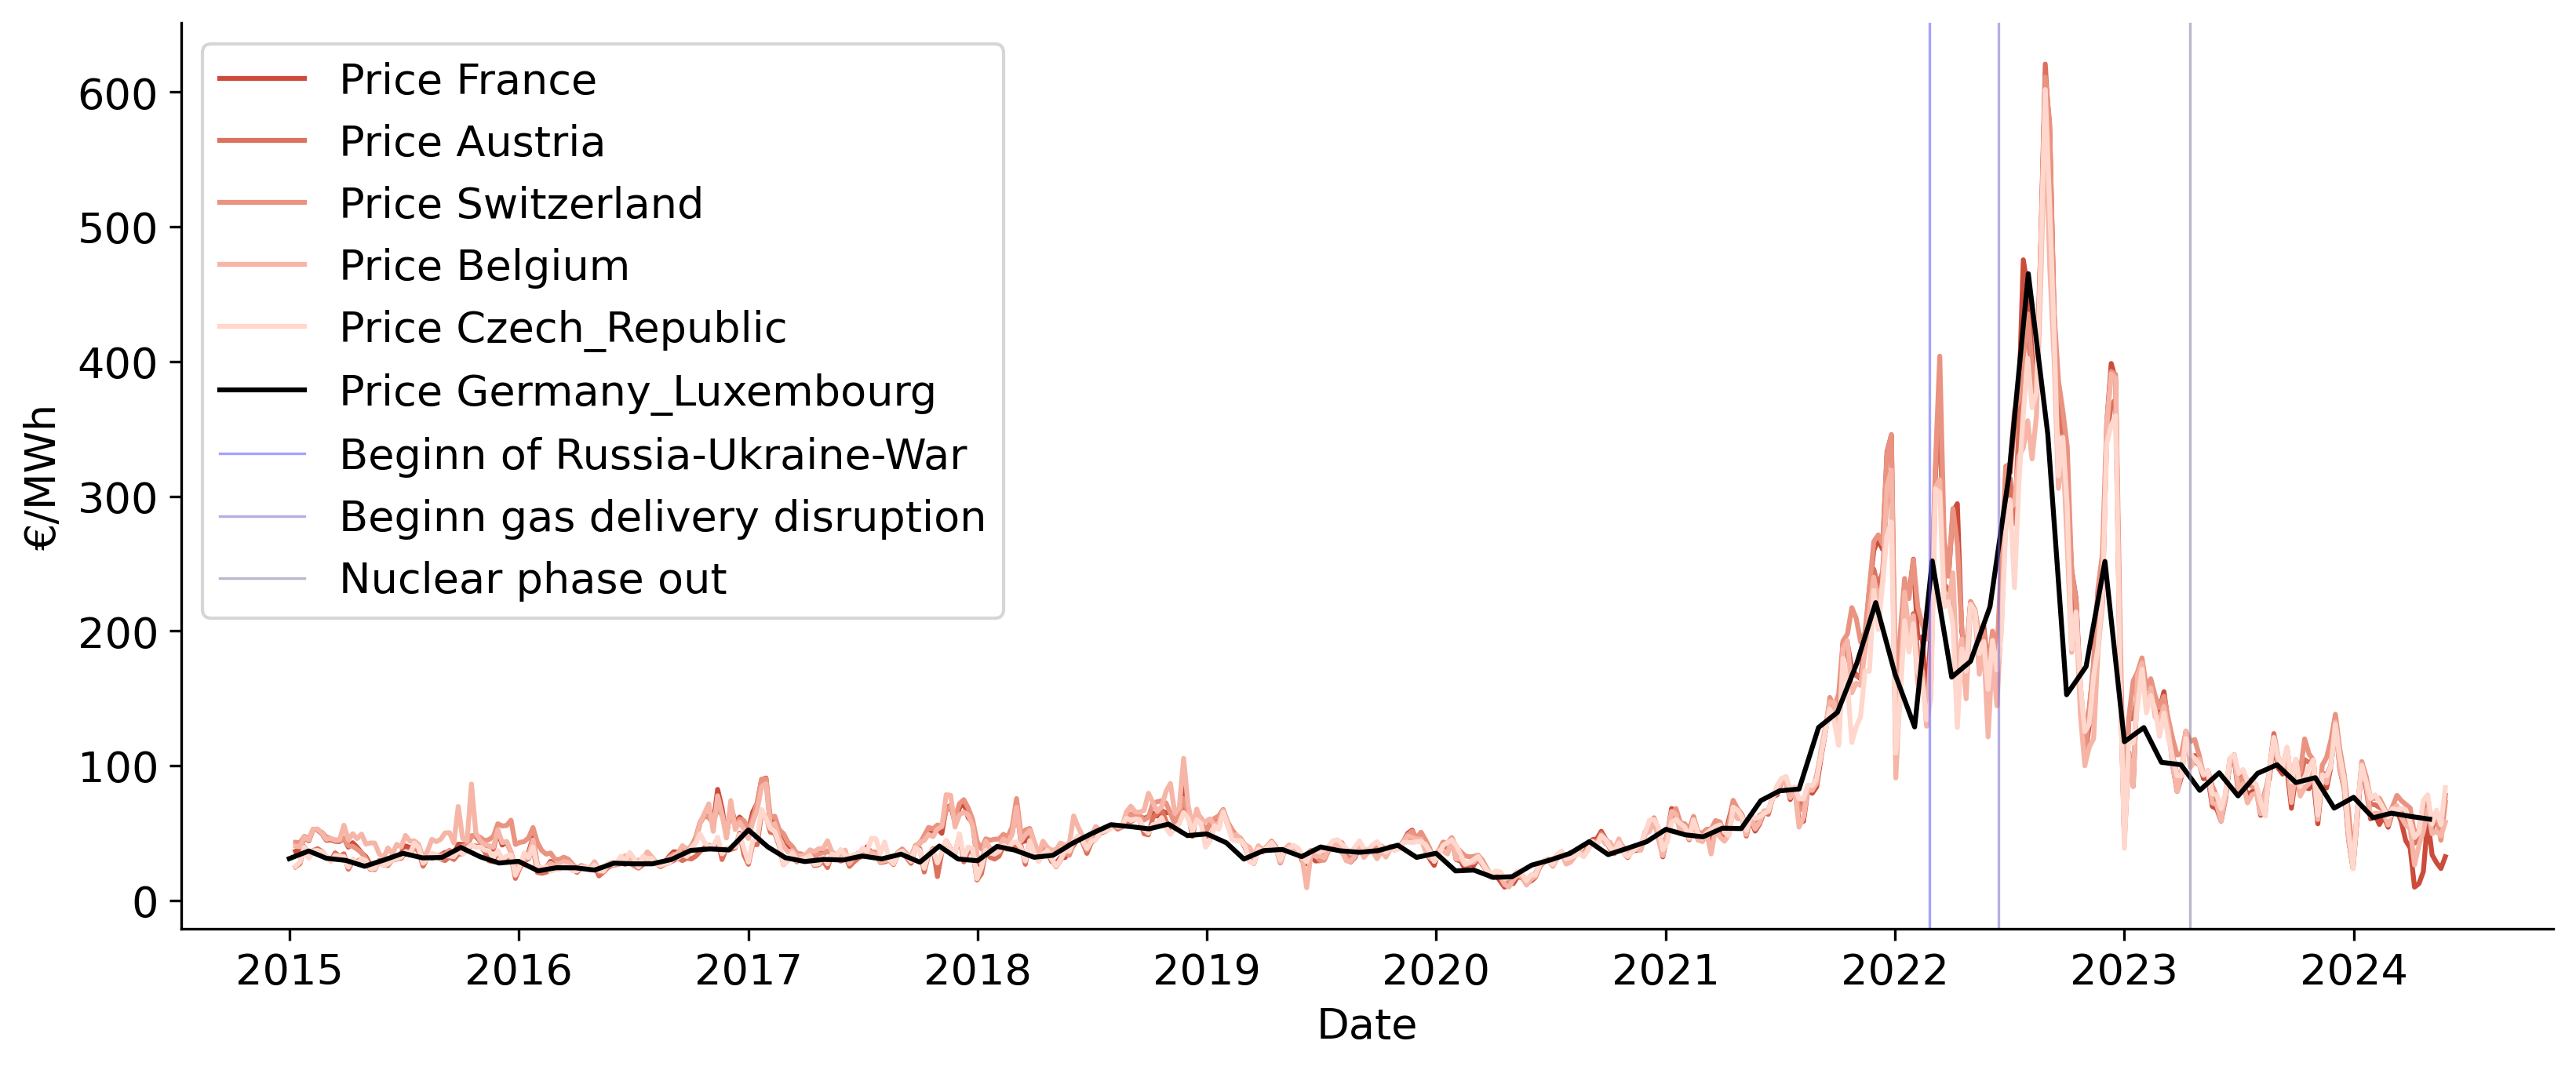

In [10]:

plt.figure(figsize= (13,5), dpi = 300)


plt.plot(Prices_FRA_weekly['France'], label = 'Price France',color='#cc4c3c')
plt.plot(Prices_Austria_weekly['Austria'], label = 'Price Austria', color='#dc715d')
plt.plot(Prices_Switzerland_weekly['Switzerland'], label = 'Price Switzerland', color='#ea9380')
plt.plot(Prices_Belgium_weekly['Belgium'], label = 'Price Belgium', color='#f6b5a6')
plt.plot(Prices_Czech_Republic_weekly['Czech_Republic'], label = 'Price Czech_Republic', color='#ffd7cd')
plt.plot(Prices_GER_monthly['Germany_Luxembourg'], label = 'Price Germany_Luxembourg',color='#000000')

plt.axvline(x=dt.datetime(2022,2,24),color = '#4a48ff', alpha = .5, linewidth = .8,  label = 'Beginn of Russia-Ukraine-War')
plt.axvline(x=dt.datetime(2022,6,14),color = '#705ec9', alpha = .5, linewidth = .8,  label = 'Beginn gas delivery disruption')
plt.axvline(x=dt.datetime(2023,4,15),color = '#7b7294', alpha = .5, linewidth = .8,  label = 'Nuclear phase out')
plt.ylabel('€/MWh')
plt.xlabel('Date')
plt.legend()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

We see the price following the same trend in all market zones, leading to irregular swings in 2022 in the wake of the energy crisis in Europe. This phase is the area of interest, as electricity generation differs from country to country in Europe, so different developments in electricity prices are to be expected in the long term. 

#### Price adjustemnt with infaltion data <a class="anchor" id="sub-heading-1"></a>

Now let's take a visual look at the infaltion. In order to better classify inflation, we will display overall inflation for visualisation purposes. 

In [11]:
# background information data
Inflation_data = pd.read_csv('../data/raw_data/prc_hicp_midx__custom_11891216_linear.csv')

Inflation_data['coicop'].replace('CP00', 'All-items', inplace=True)

Inflation_data=Inflation_data.drop(index=[0,1,111,112, 222,223]) 
Inflation_monthly = Inflation_data.loc[:,['coicop','TIME_PERIOD','OBS_VALUE']]

Inflation_monthly['TIME_PERIOD'] = pd.to_datetime(Inflation_monthly['TIME_PERIOD'], format='%Y-%m')
Inflation_monthly.set_index('TIME_PERIOD', inplace=True)

Inflation_monthly_all_items = Inflation_monthly.loc[Inflation_monthly['coicop'] == 'All-items']
Inflation_monthly_all_items= Inflation_monthly_all_items.drop(columns='coicop')

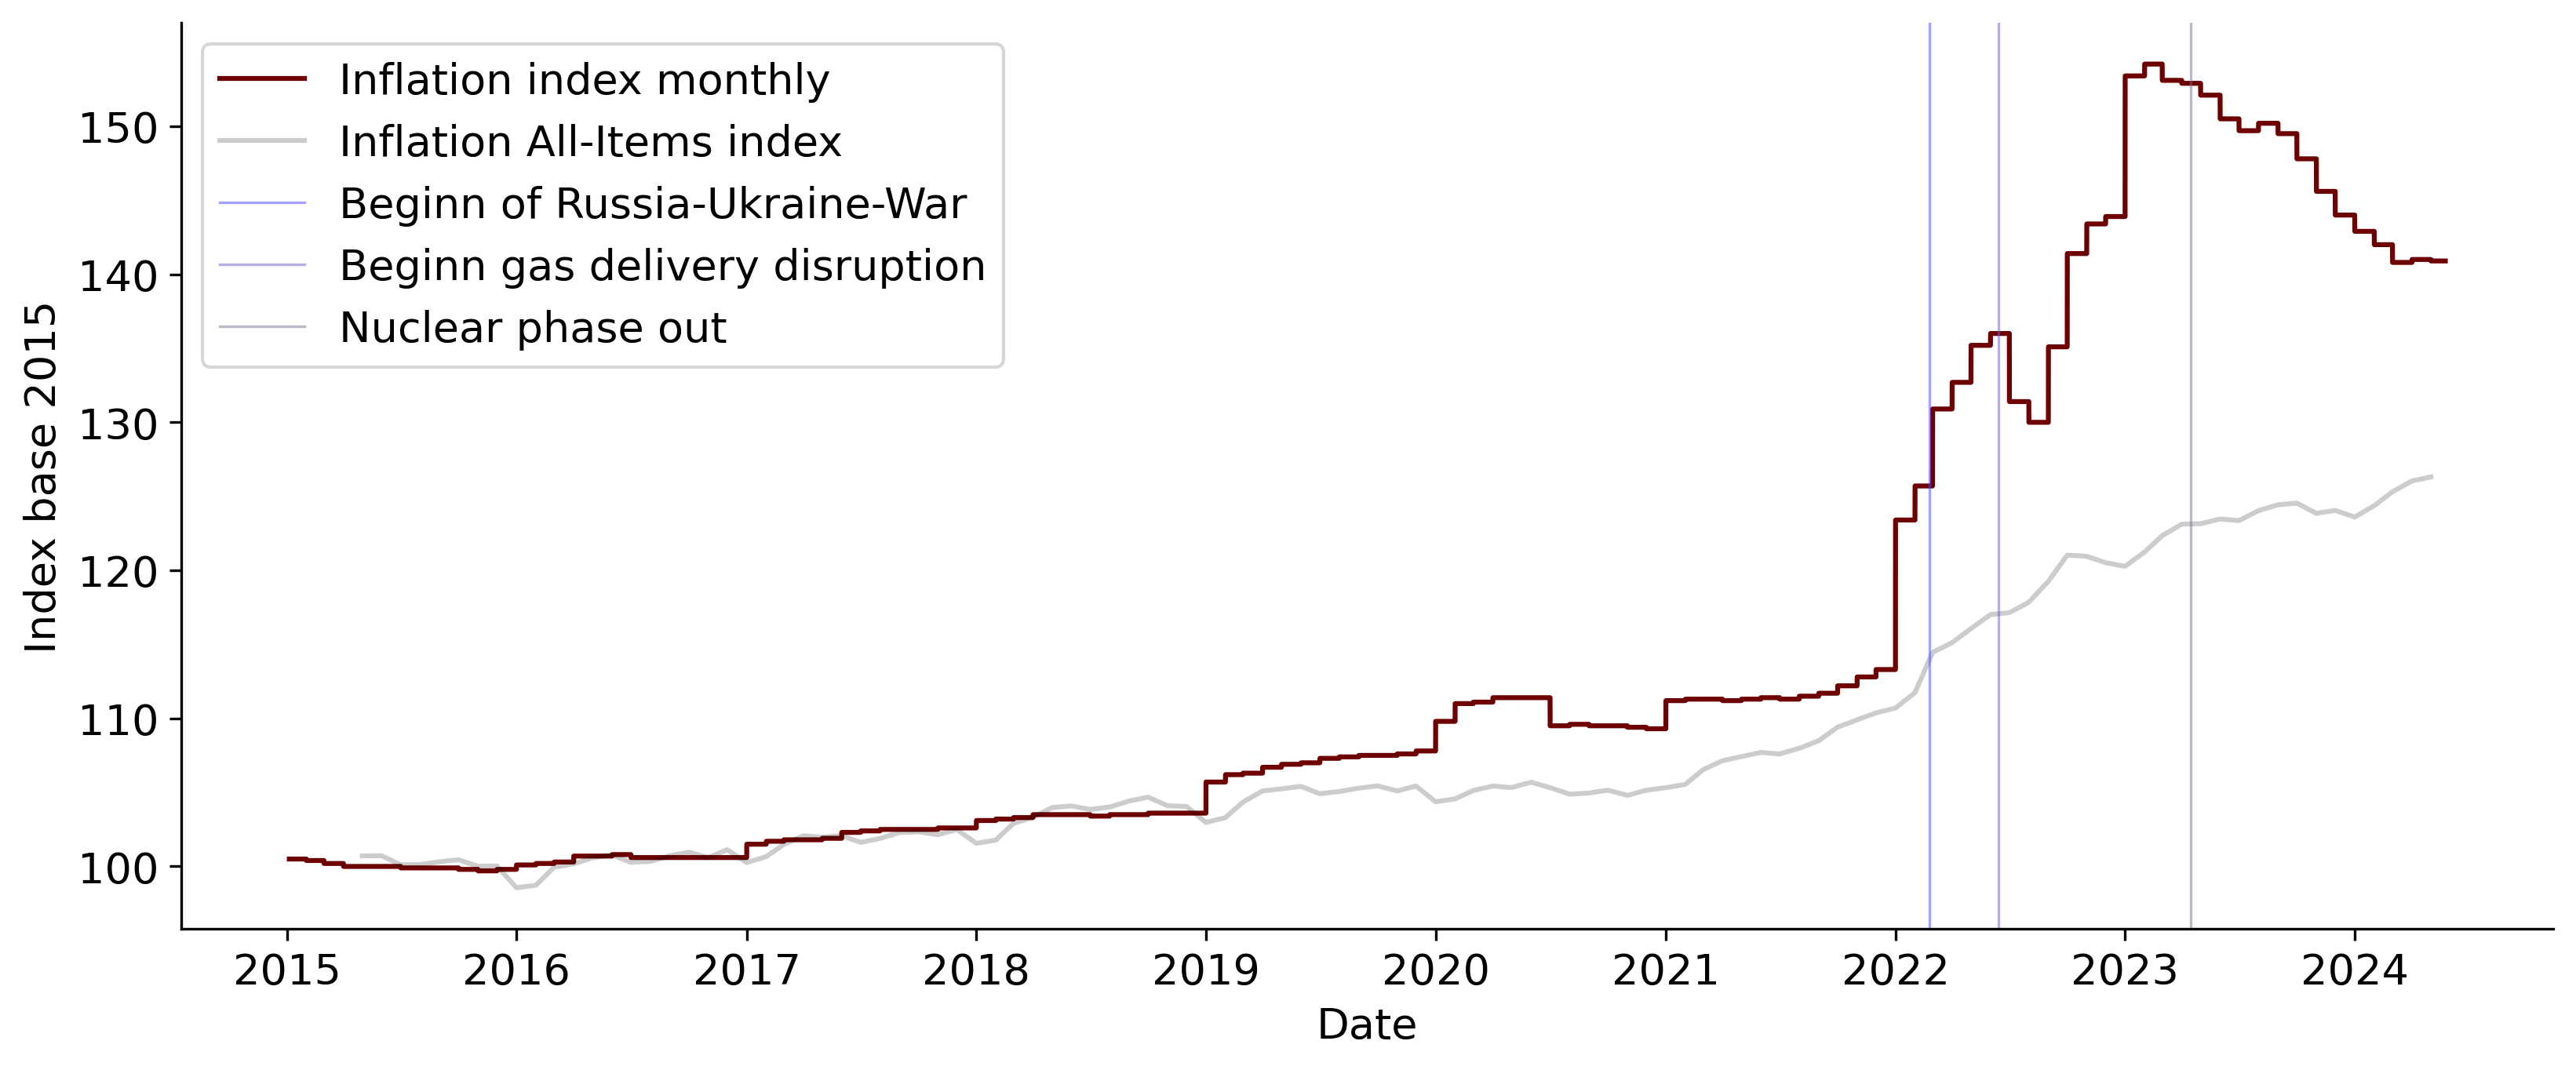

In [12]:
plt.figure(figsize= (13,5), dpi = 300)

plt.plot(Inflation_index['Germany_Luxembourg'], label = 'Inflation index monthly', color = '#6d0000')

plt.plot(Inflation_monthly_all_items['OBS_VALUE'], label = 'Inflation All-Items index',color='#000000', alpha = .2)

plt.axvline(x=dt.datetime(2022,2,24),color = '#4a48ff', alpha = .5, linewidth = .8,  label = 'Beginn of Russia-Ukraine-War')
plt.axvline(x=dt.datetime(2022,6,14),color = '#705ec9', alpha = .5, linewidth = .8,  label = 'Beginn gas delivery disruption')
plt.axvline(x=dt.datetime(2023,4,15),color = '#7b7294', alpha = .5, linewidth = .8,  label = 'Nuclear phase out')
plt.legend()
plt.ylabel('Index base 2015')
plt.xlabel('Date')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

We can see that electricity price inflation will diverge significantly from general inflation from 2022 onwards.
We see that electricity price inflation roughly follows the overall inflation until the war event, only with the accumulation of Russian troops in the border area and the rise in gas prices in the beginning of 2022 does it deviate from the path of overall inflation.
___


In order to quantify the deviations in electricity prices later, we will adjust the electricity prices accordingly for the inflation since 2015.

In [13]:
Prices['Germany_Luxembourg_adjusted'] = (Prices['Germany_Luxembourg']/ Inflation_index['Germany_Luxembourg']*100)
Prices['France_adjusted'] = (Prices['France'] / Inflation_index['France'] *100)
Prices['Belgium_adjusted'] = (Prices['Belgium'] / Inflation_index['Belgium'] *100)
Prices['Austria_adjusted'] = (Prices['Austria'] / Inflation_index['Austria'] *100)
Prices['Switzerland_adjusted'] = (Prices['Switzerland'] / Inflation_index['Switzerland'] *100)
Prices['Czech_Republic_adjusted'] = (Prices['Czech_Republic'] / Inflation_index['Czech_Republic'] *100)

#### Price adjustment with co2-prices <a class="anchor" id="sub-heading-2"></a>

In order to exclude the influence of the significantly increasing CO2 prices per ton from our analysis, the prices are also adjusted for this value.

In [14]:
co2_Prices.rename(columns ={'y_new':'Price_per_tonne'}, inplace = True)

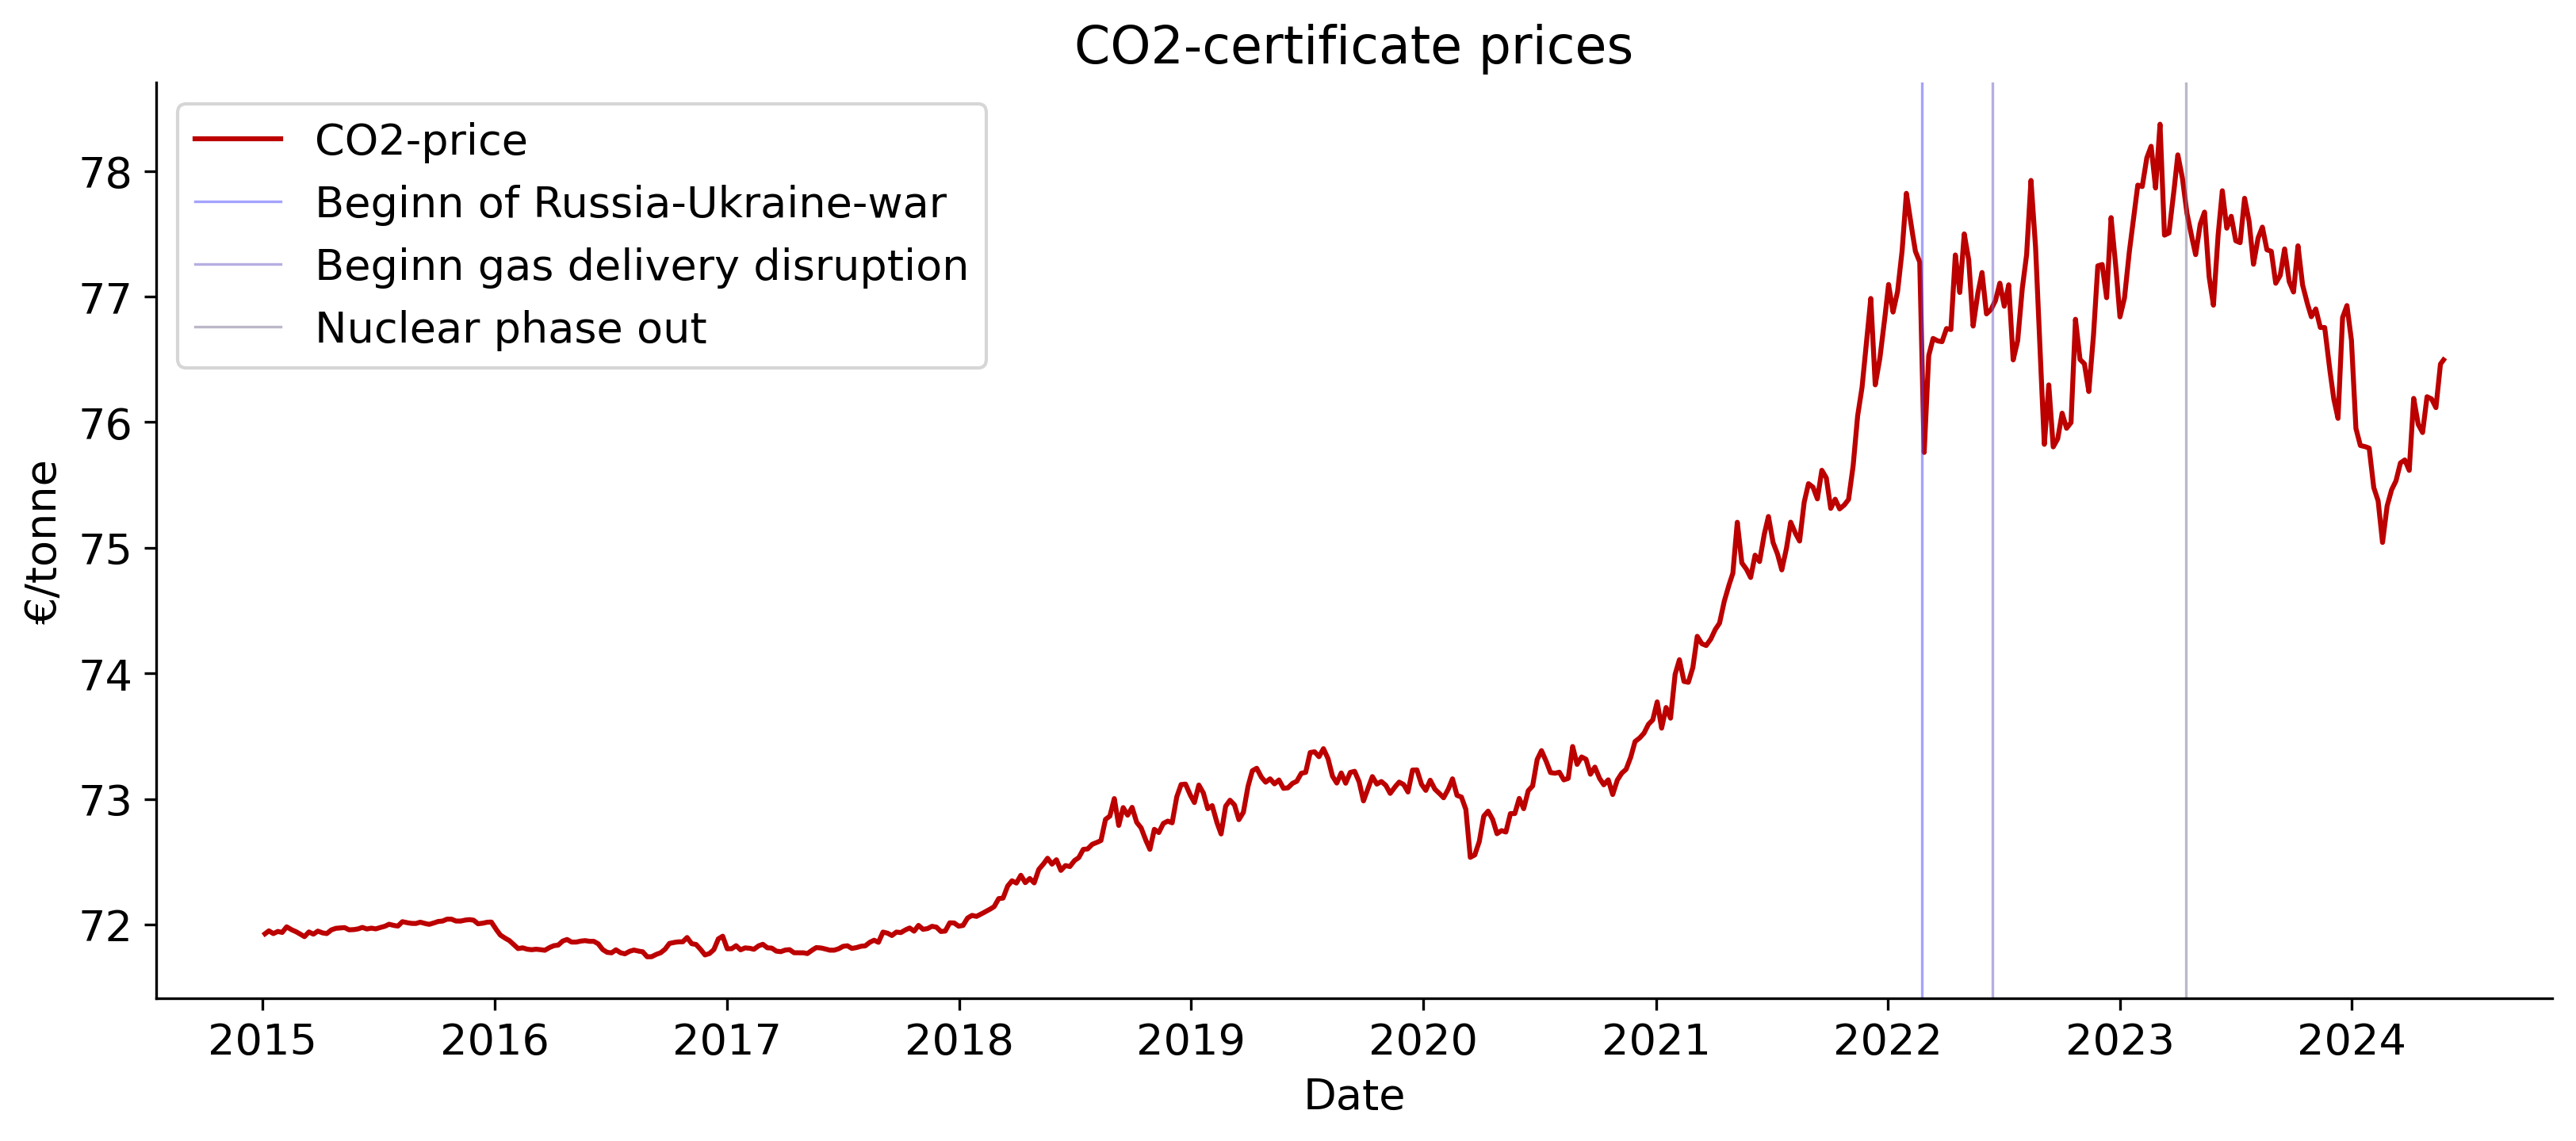

In [15]:
plt.figure(figsize= (13,5), dpi = 300)

plt.plot(co2_Prices['Price_per_tonne'], label = 'CO2-price',color='#bc0000')

plt.axvline(x=dt.datetime(2022,2,24),color = '#4a48ff', alpha = .5, linewidth = .8,  label = 'Beginn of Russia-Ukraine-war')
plt.axvline(x=dt.datetime(2022,6,14),color = '#705ec9', alpha = .5, linewidth = .8,  label = 'Beginn gas delivery disruption')
plt.axvline(x=dt.datetime(2023,4,15),color = '#7b7294', alpha = .5, linewidth = .8,  label = 'Nuclear phase out')
plt.legend()
plt.title('CO2-certificate prices')
plt.ylabel('€/tonne')
plt.xlabel('Date')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

We see a similar trend to inflation here, but the rise in CO2 certificate costs is also a political decision, due to the setting of price floors. 
As the CO2 prices only relate to CO2-intensive forms of electricity generation, we divide the generation table as follows

In [16]:
Generation['Renewables_sum'] = Generation[['Biomass','Hydropower','Wind_offshore', 'Wind_onshore','Photovoltaics', 'Other_renewable','Hydro_pumped_storage']].sum(axis=1)
Generation['CO2_Conventionals_sum'] = Generation[['Lignite','Hard_coal','Fossil_gas','Other_conventional']].sum(axis=1)
Generation['Conventionals_sum'] = Generation[['CO2_Conventionals_sum','Nuclear']].sum(axis=1)

Generation contains now many different sums, therefore I provide the following:

|       | **Generation - sums** | **Note**              |         |                       | **Note**                                |
|-------|-----------------------|-----------------------|---------|-----------------------|-----------------------------------------|
|       |                       |                       |         |                       |                                         |
| +     | Import sum            | Sum of all imports    | +/-     | Belgium_sum           |                                         |
| -     | Export_sum            | Sum of all exports    | +/-     | France_sum            |                                         |
|       |                       |                       | +/-     | Poland_sum            |                                         |
|       |                       |                       | +/-     | Austria_sum           |                                         |
|       |                       |                       | +/-     | Czech_Republic_sum    |                                         |
|       |                       |                       | +/-     | Switzerland_sum       |                                         |
|       |                       |                       | +/-     | Remainder_sum         |                                         |
| =     | Import_Export_sum     |                       | =       | Import_Export_sum     | Export is negative, Import is positive  |
|       |                       |                       |         |                       |                                         |
| +     | Generation_sum        |                       | +       | CO2_Conventionals     | Conventionals who emitting CO2 directly |
|       |                       |                       | +       | Nuclear               |                                         |
|       |                       |                       | =       | Conventionals_sum     |                                         |
|       |                       |                       | +       | Renewables_sum        |                                         |
|       |                       |                       | =       | Generation_sum        |                                         |
| **=** | **Total_sum**         | **total sum**         | **=**   | **Total_sum**         | **total sum**                           |
| **-** | **-----------------** | **-----------------** | **---** | **-----------------** | **-----------------**                   |

Co2 per MWh Generation:

Sources: 
https://view.officeapps.live.com/op/view.aspx?src=https%3A%2F%2Fwww.umweltbundesamt.de%2Fsites%2Fdefault%2Ffiles%2Fmedien%2F361%2Fdokumente%2Fco2_ef_liste_2022_brennstoffe_und_industrie_final.xlsx&wdOrigin=BROWSELINK


Ohter conventionals = avg of Hard_coal, Lignite and Fossil gas as a aproximation
t CO2/ MWh:

In [17]:
Co2_per_Generation = {'Lignite': 0.3929 , 'Hard_coal': 0.3382, 'Fossil_gas':0.2198, 'Nuclear': 0.0, 'Other_conventional': 0.3169}

Two sub dataframes are created for better and easier controllability

In [18]:
Conventional_generation = Generation[['Lignite','Hard_coal','Fossil_gas','Nuclear','Other_conventional']]
Renewable_generation = Generation[['Biomass','Hydropower','Wind_offshore', 'Wind_onshore','Photovoltaics', 'Other_renewable','Hydro_pumped_storage']]

The co2-adjustment is done as described below: 

**The cost per form of energy**, caused by its specific emissions per technology ```[i]``` multiplied by the CO2 emission price:

```python
Co2_Prices_per_Generation[i] = Conventional_generation[i]*Co2_per_Generation[i]*co2_Prices['Price_per_tonne']
```
gives the total **Co2 pollution costs** of all CO2-intensive forms of production per week: 

```python
Co2_Prices_per_Generation['sum'] = Co2_Prices_per_Generation.loc[:, Co2_conventionals].sum(axis=1)
```

**The value of the generation in each week corresponds to:**

```python
Co2_Prices_per_Generation['value_of_generation'] = Generation['Generation_sum']*Prices_GER['Germany_Luxembourg_adjusted']

```
**... the MWh multiplied by the inflation-adjusted price. The Co2 pollution costs  is deducted from this value each week.**
The subtraction of the value of all Generation minus the CO2 Pollution costs results in 
```python
Co2_Prices_per_Generation['value_of_generation_adjusted'] = Co2_Prices_per_Generation['value_of_generation']-
                                                                Co2_Prices_per_Generation['sum']
```
the value of the **generation without the Co2 pricing**, as this was originally included in the price. This divided by the original generation gives the adjusted price 
```python
Prices['Germany_Luxembourg_adjusted'] = Co2_Prices_per_Generation['value_of_generation_adjusted'] /
                                                                    Generation['Generation_sum']
```

In [19]:
Co2_conventionals = list(Conventional_generation.columns)

In [20]:
Co2_Prices_per_Generation = pd.DataFrame()
for i in Co2_conventionals:
    Co2_Prices_per_Generation[i] = Conventional_generation[i]*Co2_per_Generation[i]*co2_Prices['Price_per_tonne']
    
Co2_Prices_per_Generation['sum'] = Co2_Prices_per_Generation.loc[:, Co2_conventionals].sum(axis=1)

Co2_Prices_per_Generation['value_of_generation'] = Generation['Generation_sum']*Prices['Germany_Luxembourg_adjusted']

Co2_Prices_per_Generation['value_of_generation_adjusted'] = Co2_Prices_per_Generation['value_of_generation']-Co2_Prices_per_Generation['sum']

Prices['Germany_Luxembourg_co2_adjusted'] = Co2_Prices_per_Generation['value_of_generation_adjusted'] /Generation['Generation_sum']
Co2_Prices_per_Generation['Percentage_of_price'] = Co2_Prices_per_Generation['sum']/Co2_Prices_per_Generation['value_of_generation']*100

Plotting of the price adjustments

In [21]:
Prices_GER_weekly_co2 = decomposition_df(Prices, 'Germany_Luxembourg_co2_adjusted','W','mean')
Prices_GER_weekly_infl = decomposition_df(Prices, 'Germany_Luxembourg_adjusted','W','mean')
Prices_GER_weekly = decomposition_df(Prices, 'Germany_Luxembourg','W','mean')

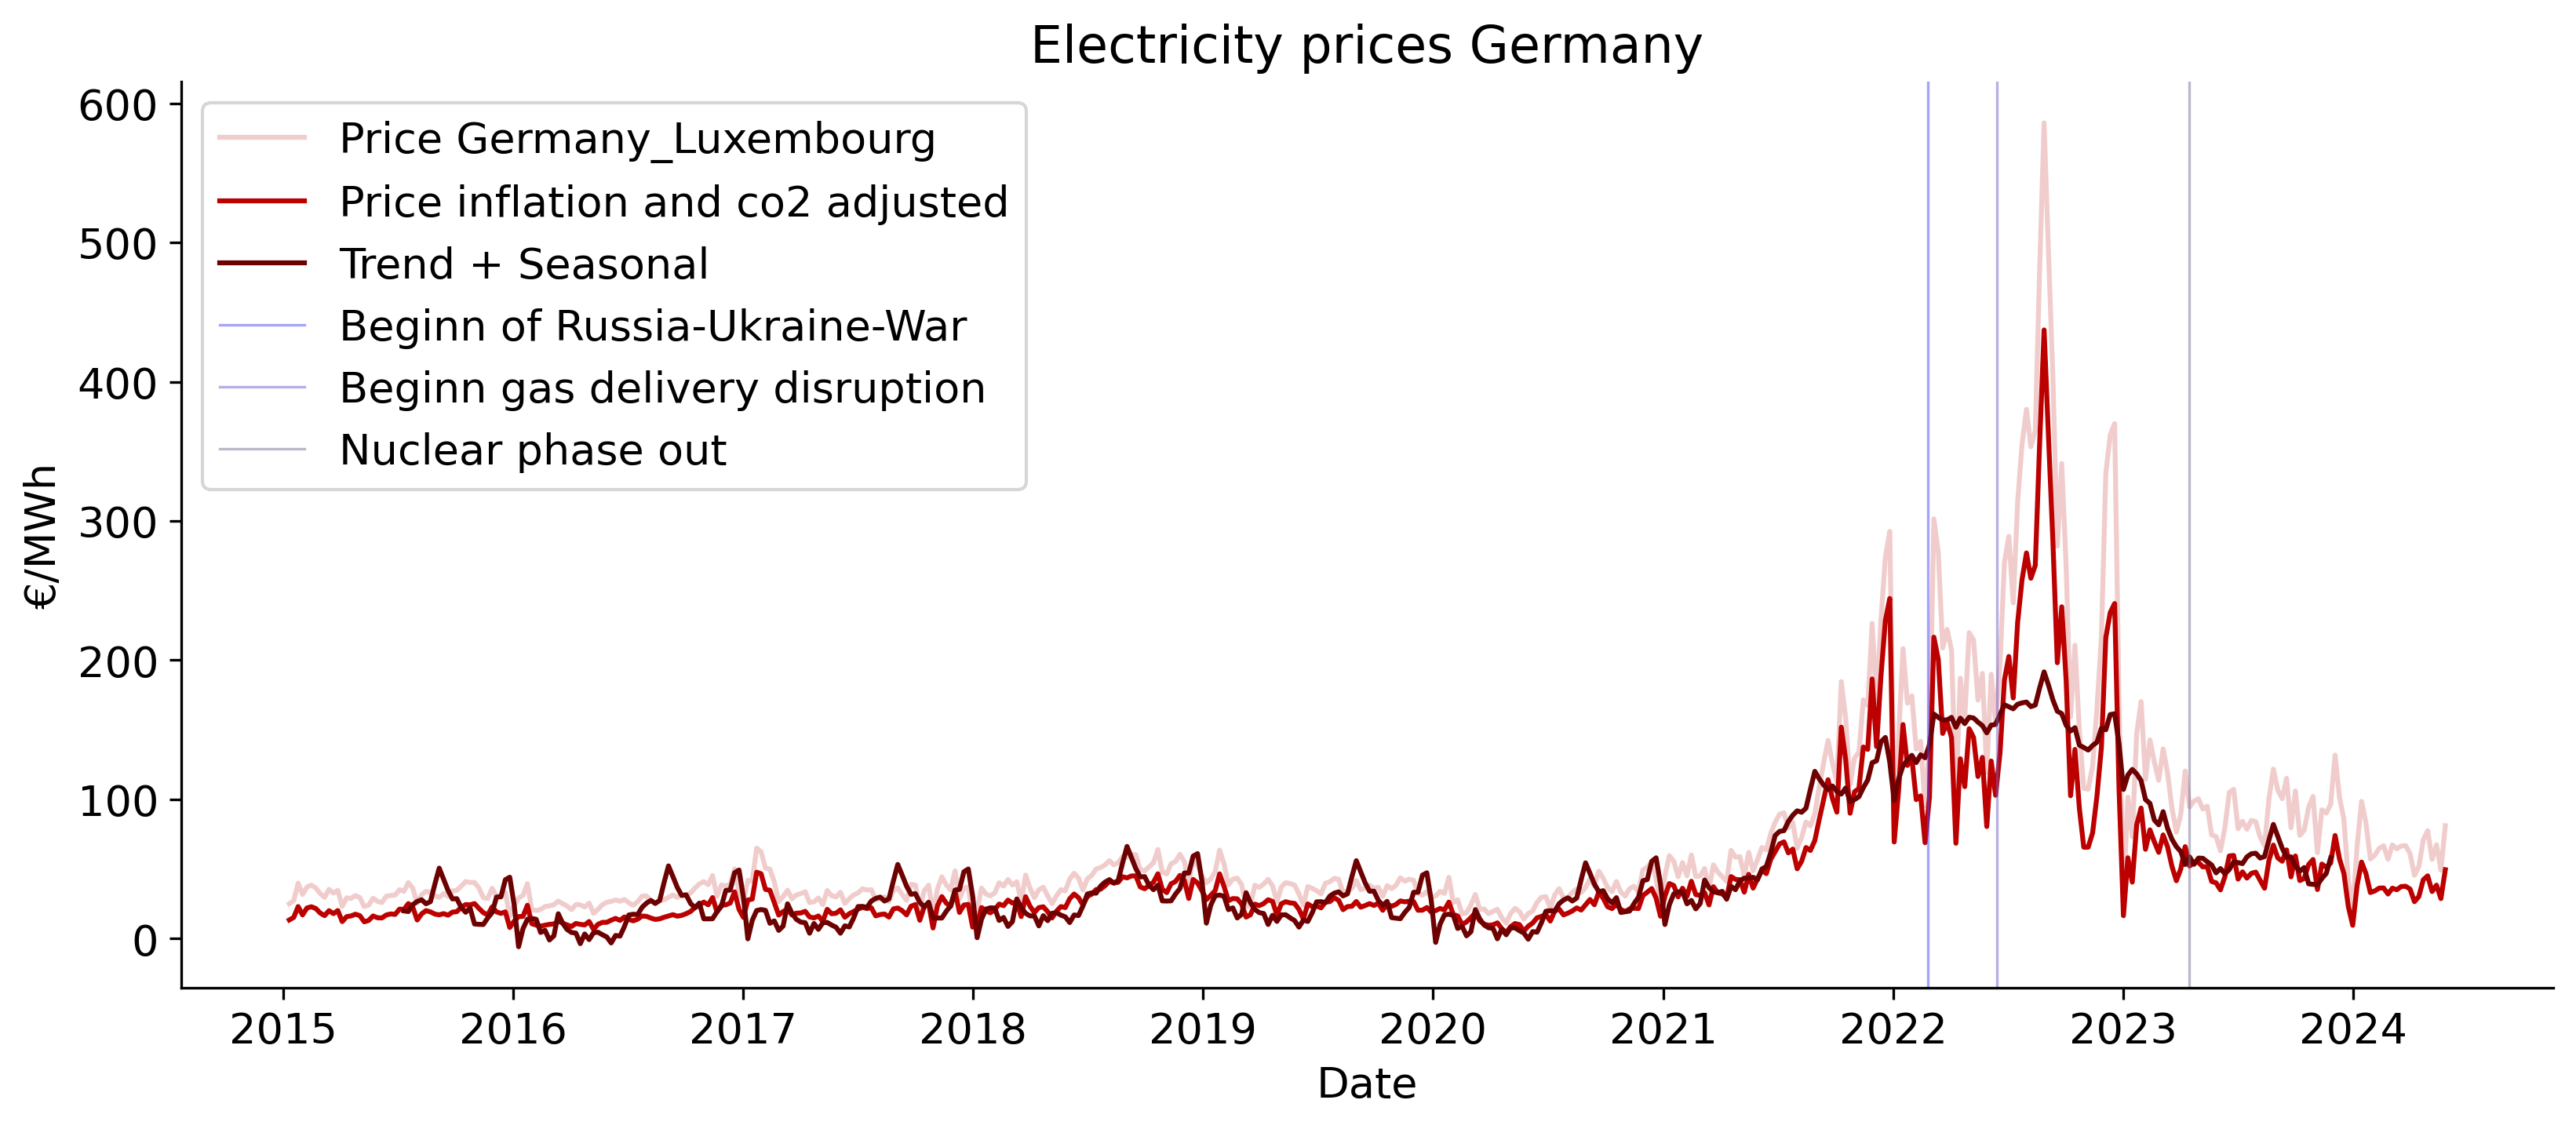

In [22]:
plt.figure(figsize= (13,5), dpi = 300)


plt.plot(Prices_GER_weekly['Germany_Luxembourg'], label = 'Price Germany_Luxembourg',color='#bc0000', alpha =.2)
plt.plot(Prices_GER_weekly_co2['Germany_Luxembourg_co2_adjusted'], label = 'Price inflation and co2 adjusted',color='#bc0000')
plt.plot(Prices_GER_weekly_co2['Trend+Seasonal'], label = 'Trend + Seasonal', color = '#6d0000')


plt.axvline(x=dt.datetime(2022,2,24),color = '#4a48ff', alpha = .5, linewidth = .8,  label = 'Beginn of Russia-Ukraine-War')
plt.axvline(x=dt.datetime(2022,6,14),color = '#705ec9', alpha = .5, linewidth = .8,  label = 'Beginn gas delivery disruption')
plt.axvline(x=dt.datetime(2023,4,15),color = '#7b7294', alpha = .5, linewidth = .8,  label = 'Nuclear phase out')
plt.legend()
plt.title('Electricity prices Germany')
plt.ylabel('€/MWh')
plt.xlabel('Date')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

In [44]:
Prices_GER_weekly_infl

,Germany_Luxembourg_adjusted,Trend,Seasonal,Residual,Trend+Seasonal
Start,,,,,
2015-01-11,24.897062,NaN,-22.994664,NaN,NaN
2015-01-18,27.224236,NaN,-8.104589,NaN,NaN
2015-01-25,39.637349,NaN,-0.535255,NaN,NaN
2015-02-01,31.580542,NaN,0.528603,NaN,NaN
2015-02-08,36.836167,NaN,-0.506380,NaN,NaN
...,...,...,...,...,...
2024-04-28,54.997003,NaN,-10.890391,NaN,NaN
2024-05-05,40.352005,NaN,-10.877564,NaN,NaN
2024-05-12,47.786931,NaN,-12.697874,NaN,NaN


We have negated the influences of inflation and the CO2 price.

#### Trend-Seasonal-Decomposition

We now analyze our data using the decomposition into trend, seasonality and residual

Trend of electricity prices

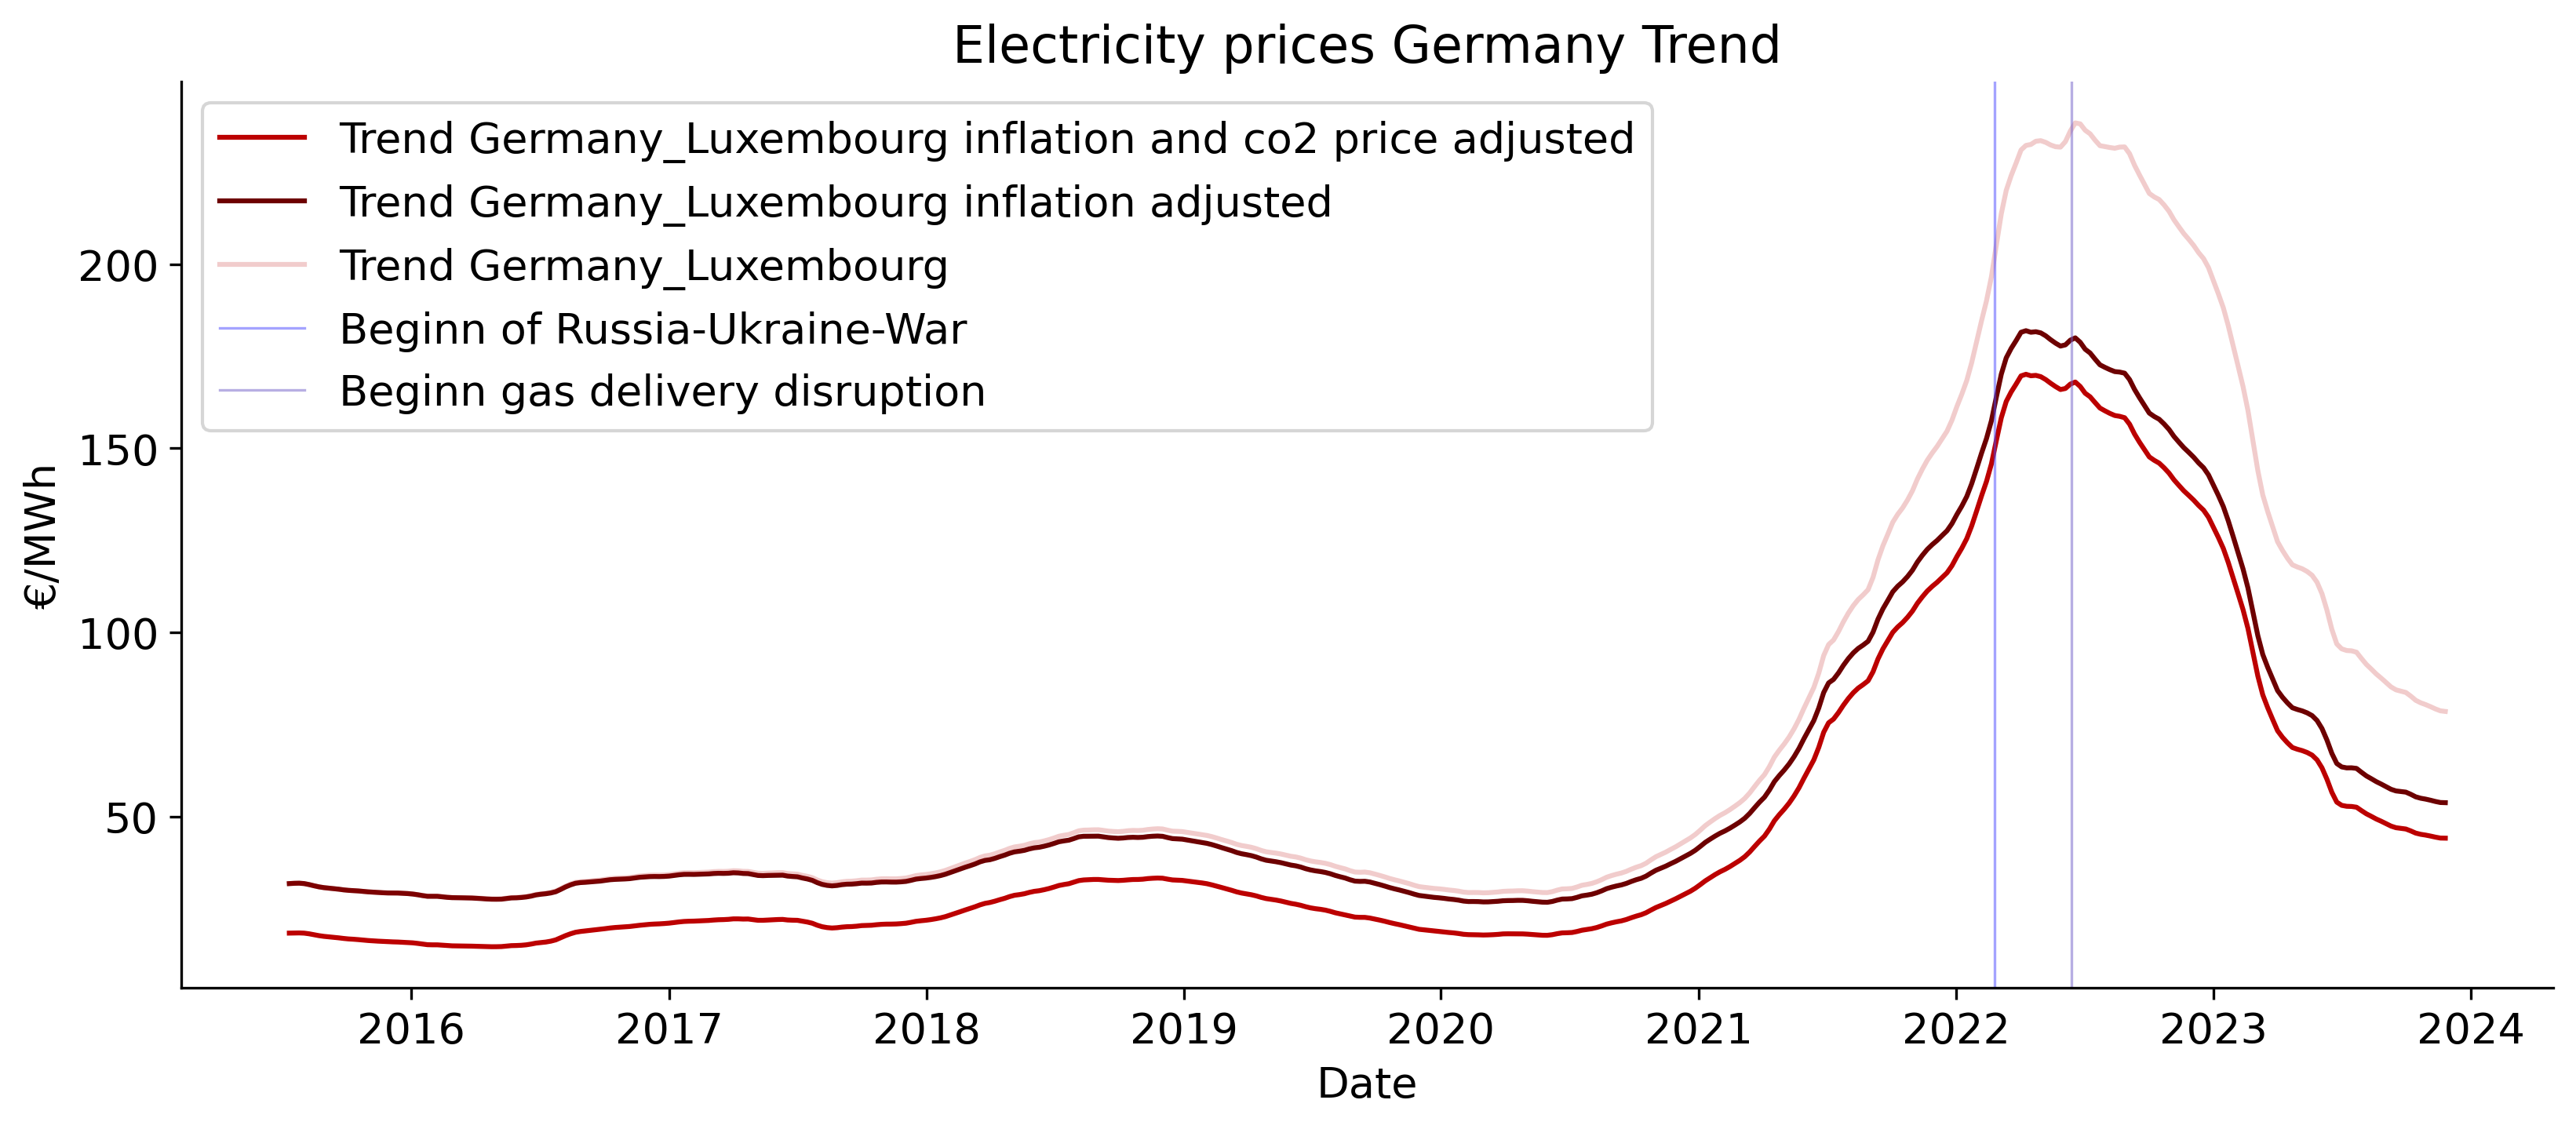

In [69]:
plt.figure(figsize= (13,5), dpi = 300)

plt.plot(Prices_GER_weekly_co2['Trend'], label = 'Trend Germany_Luxembourg inflation and co2 price adjusted', color = '#bc0000')
plt.plot(Prices_GER_weekly_infl['Trend'], label = 'Trend Germany_Luxembourg inflation adjusted', color = '#6d0000')
plt.plot(Prices_GER_weekly['Trend'], label = 'Trend Germany_Luxembourg', color = '#bc0000' ,alpha = .2)


plt.axvline(x=dt.datetime(2022,2,24),color = '#4a48ff', alpha = .5, linewidth = .8,  label = 'Beginn of Russia-Ukraine-War')
plt.axvline(x=dt.datetime(2022,6,14),color = '#705ec9', alpha = .5, linewidth = .8,  label = 'Beginn gas delivery disruption')
#plt.axvline(x=dt.datetime(2023,4,15),color = '#7b7294', alpha = .5, linewidth = .8,  label = 'Nuclear phase out')
plt.legend()
plt.title('Electricity prices Germany Trend')
plt.ylabel('€/MWh')
plt.xlabel('Date')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

We observe that the adjustment of inflation and CO2 prices after the start of the war has a greater impact than before the war. We see that the increase in electricity prices began before these events and is mainly explained by the recovery of the economy after the corona pandemic. The increased demand combined with a fragile supply chain and an increase in consumption after the end of the restrictions led to a general increase in inflation and thus also in the price of electricity. However, since we only adjusted electricity prices for electricity price inflation, which only stopped following overall inflation after the start of the war, the reduction in the increase before the war is smaller.

Seasonality of electricity prices

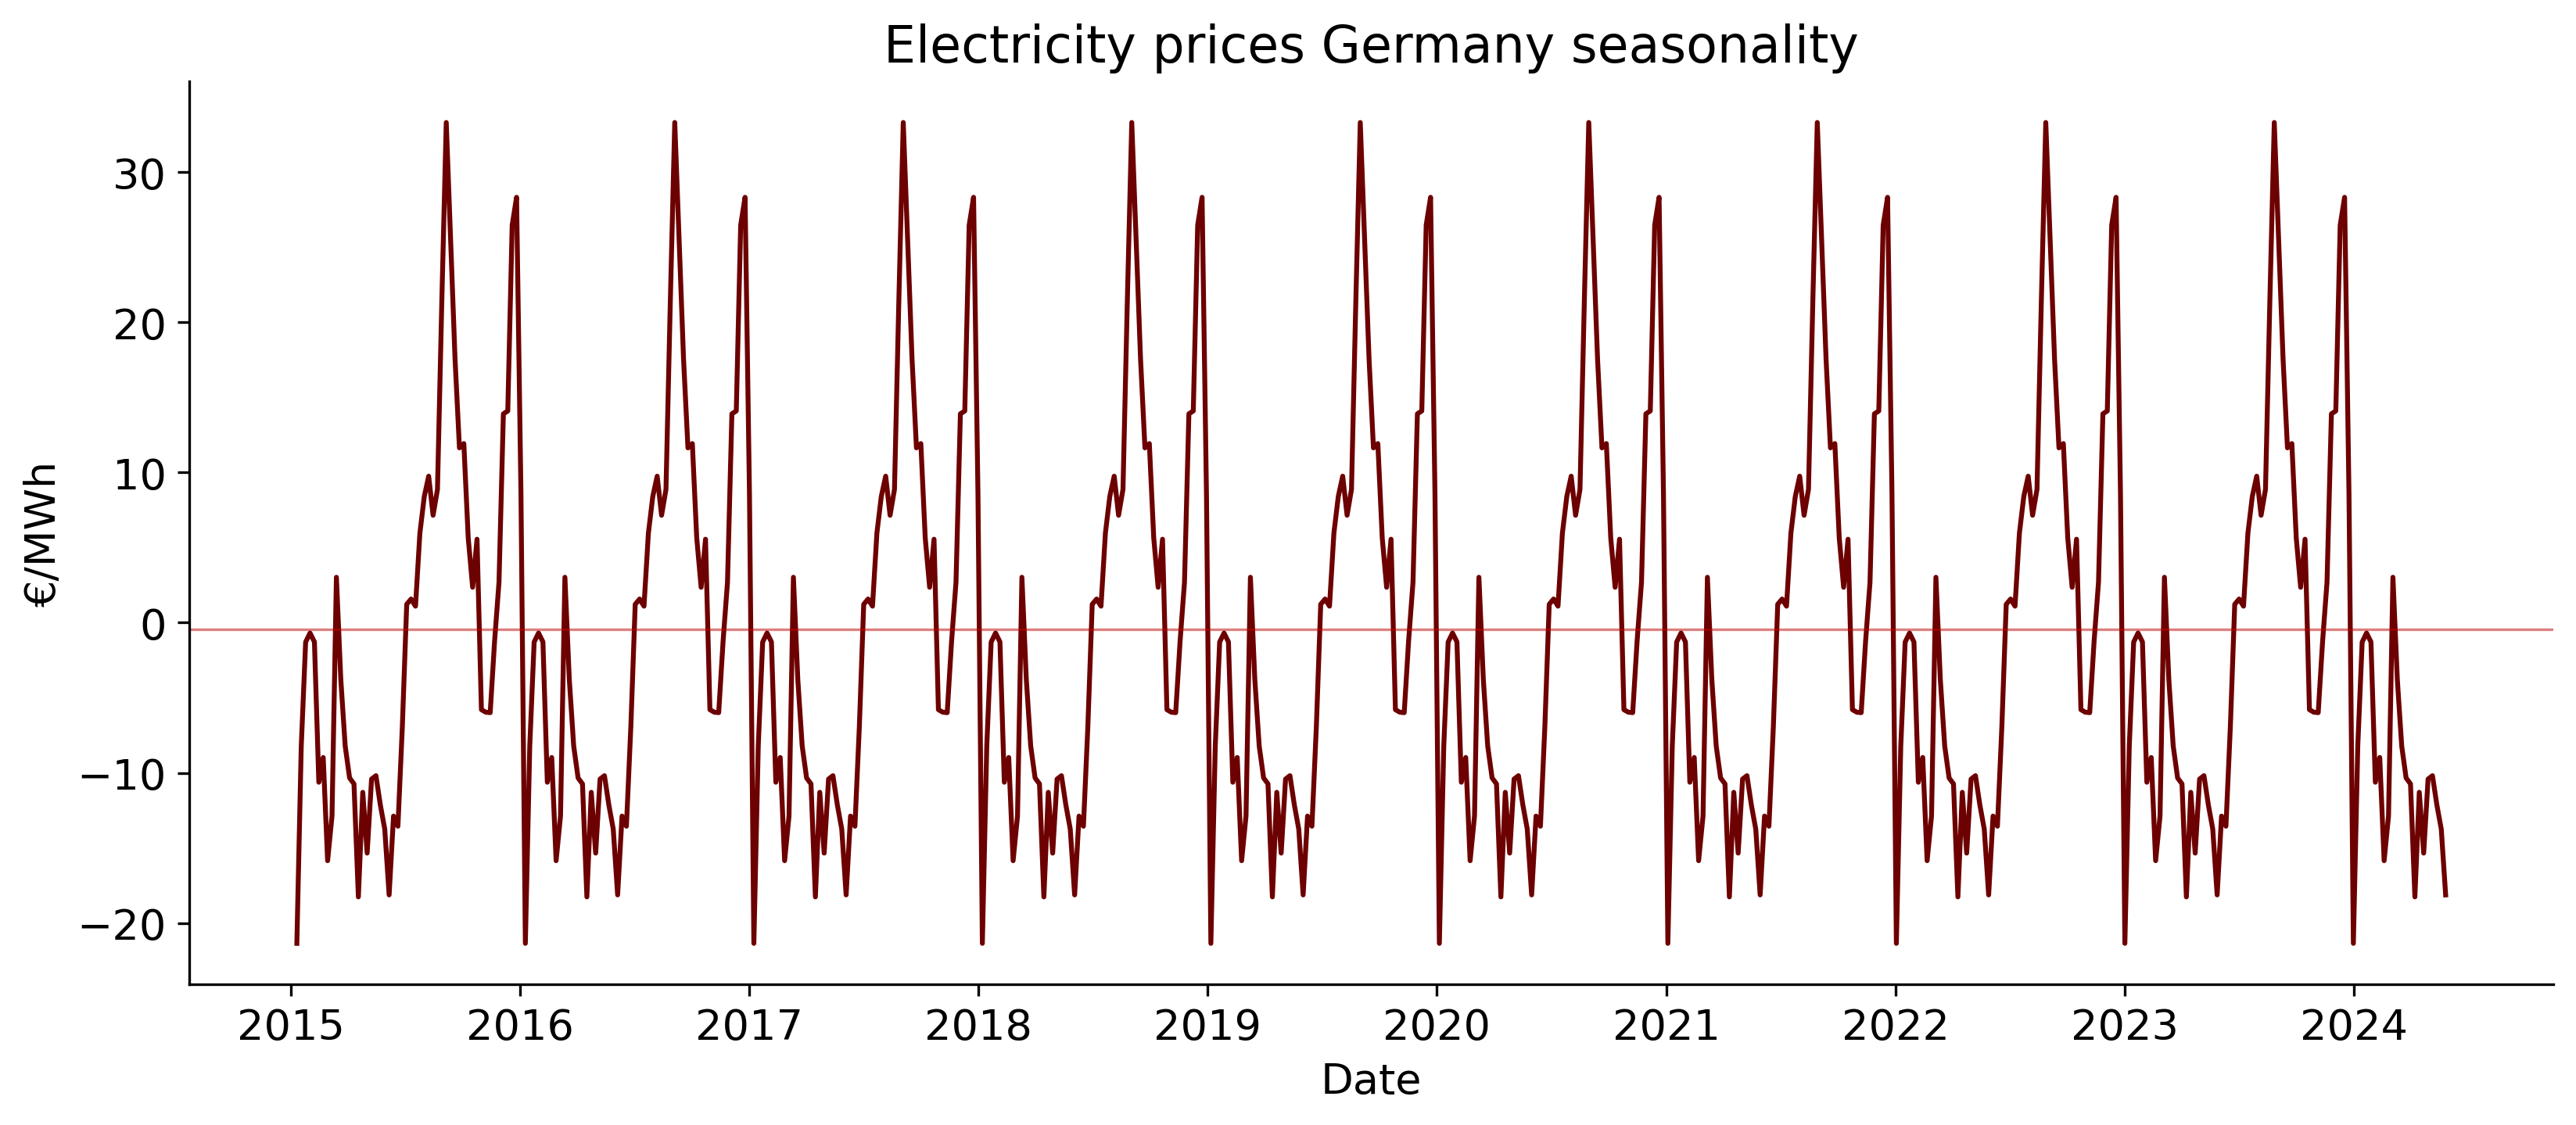

In [70]:
mean_Prices_GER_weekly_seasonal = np.mean(Prices_GER_weekly_co2['Seasonal'])


plt.figure(figsize= (13,5), dpi = 300)


plt.plot(Prices_GER_weekly_co2['Seasonal'], label = 'Seasonal Germany_Luxembourg', color = '#6d0000')




plt.axhline(y=mean_Prices_GER_weekly_seasonal,color = '#bc0000', alpha = .5, linewidth = .8,  label = 'Residual mean')

plt.title('Electricity prices Germany seasonality')
plt.ylabel('€/MWh')
plt.xlabel('Date')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

#plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()



We see that despite the increase from the end of 2021, the seasonality of the electricity price remains constant. We see that the electricity price is higher in the middle and at the end of the year than at the beginning of the year and that this pattern does not change over the years

Residuals 

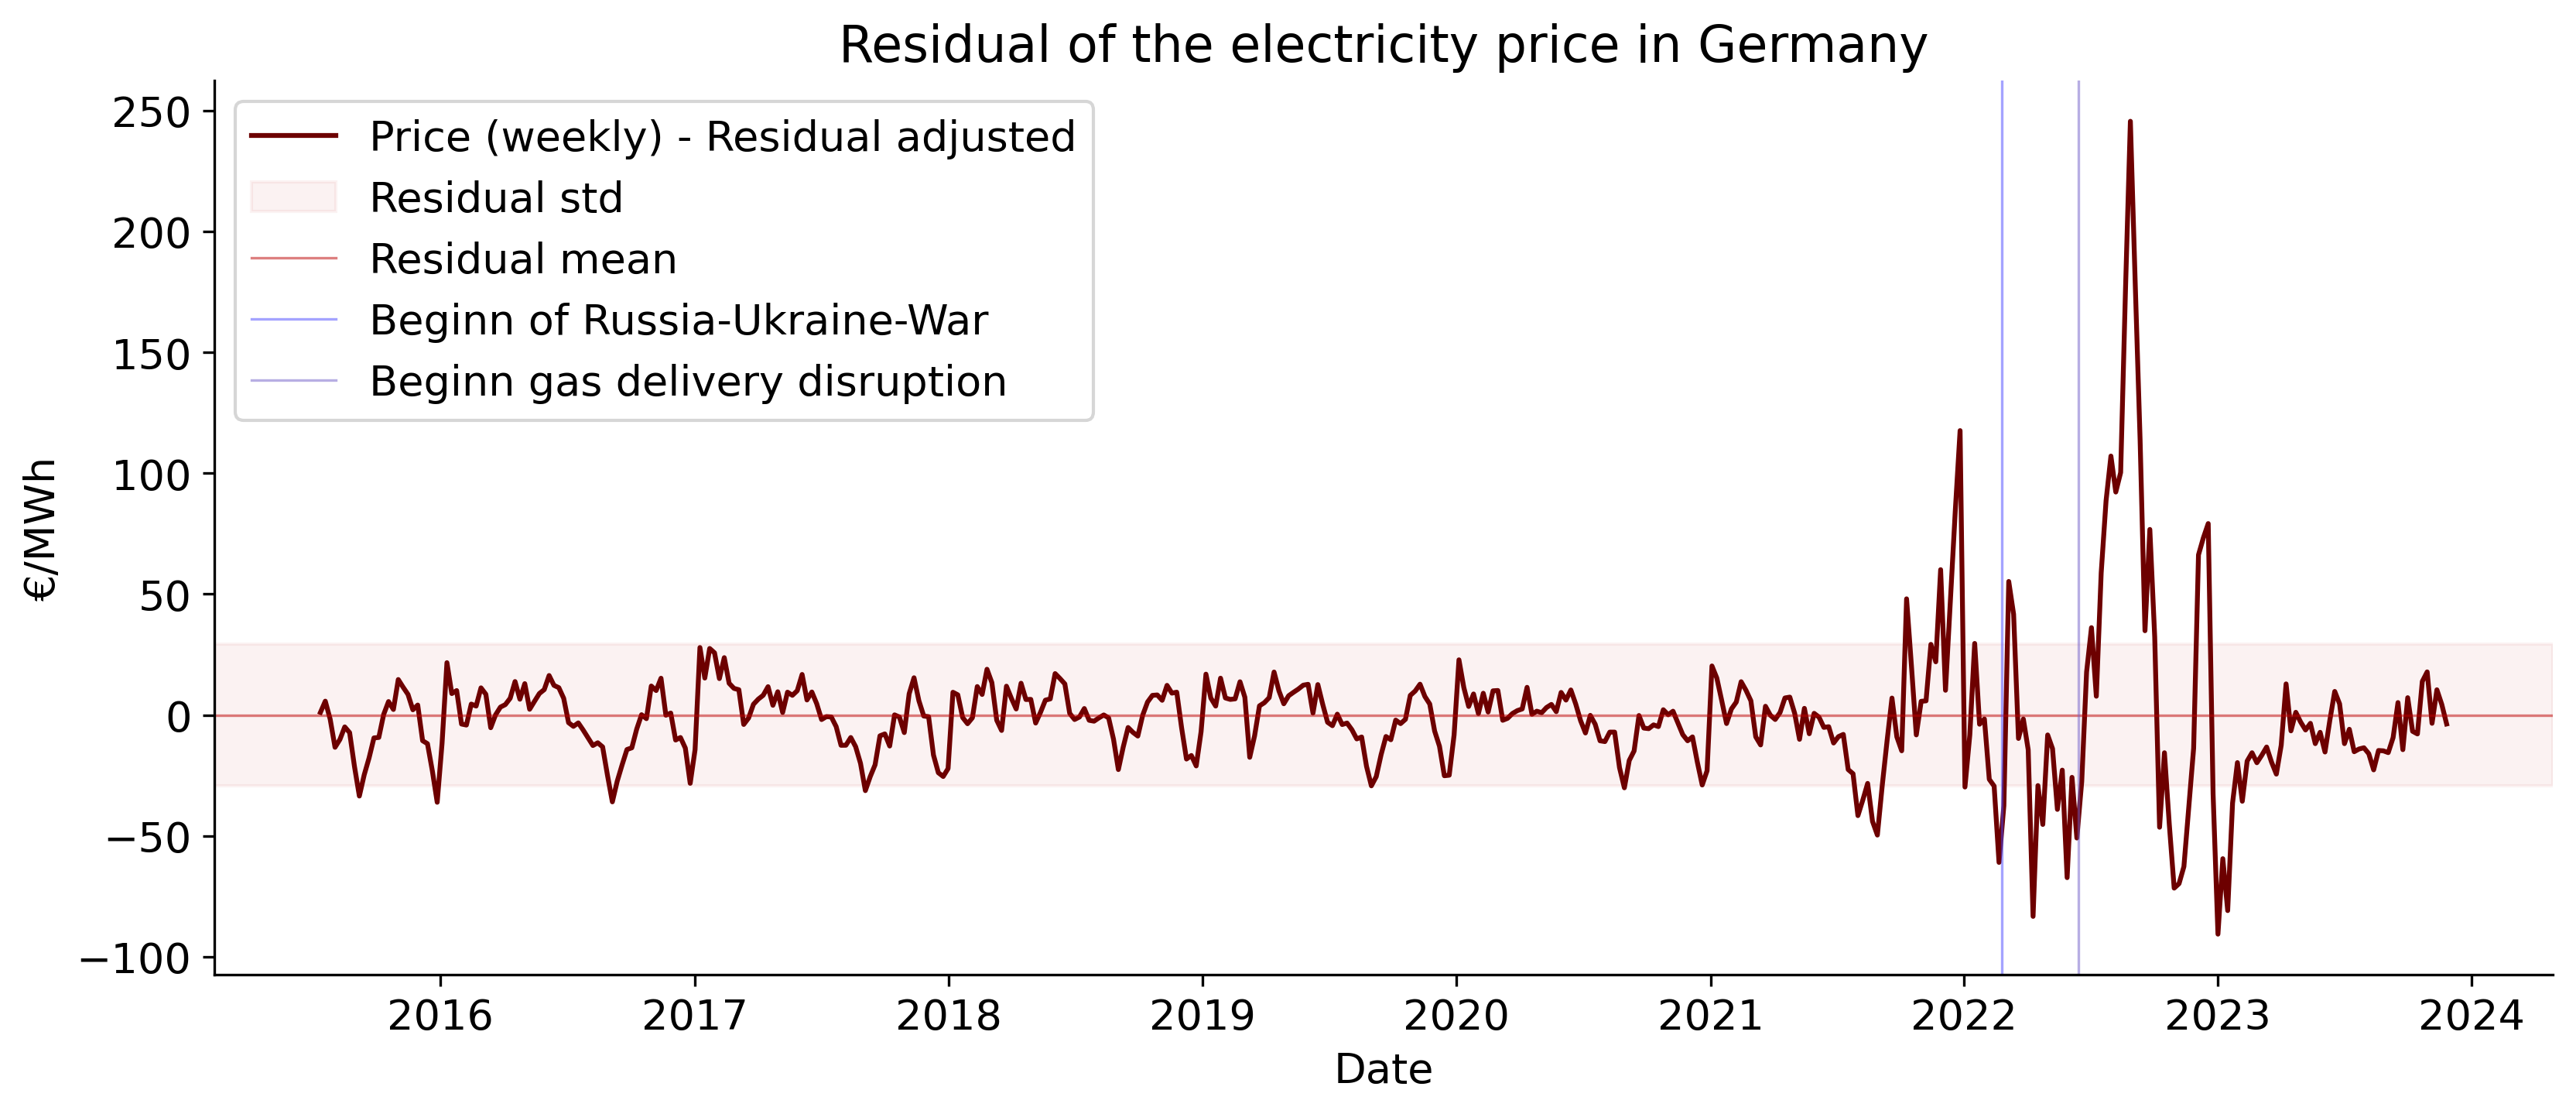

mean_Prices_GER_weekly_residual: -0.2
std_Prices_GER_weekly_residual: 29.18


In [71]:
mean_Prices_GER_weekly_residual = np.mean(Prices_GER_weekly_co2['Residual'])
std_Prices_GER_weekly_residual = np.std(Prices_GER_weekly_co2['Residual'])


plt.figure(figsize= (13,5), dpi = 300)

plt.plot(Prices_GER_weekly_co2['Residual'], label = 'Price (weekly) - Residual adjusted', color = '#6d0000')
plt.axhspan(ymin=-std_Prices_GER_weekly_residual,ymax=std_Prices_GER_weekly_residual, alpha = 0.05, label = 'Residual std',color = '#bc0000')
plt.axhline(y=mean_Prices_GER_weekly_residual,color = '#bc0000', alpha = .5, linewidth = .8,  label = 'Residual mean')



plt.axvline(x=dt.datetime(2022,2,24),color = '#4a48ff', alpha = .5, linewidth = .8,  label = 'Beginn of Russia-Ukraine-War')
plt.axvline(x=dt.datetime(2022,6,14),color = '#705ec9', alpha = .5, linewidth = .8,  label = 'Beginn gas delivery disruption')
#plt.axvline(x=dt.datetime(2022,8,31),color = '#705ec9', alpha = .5, linewidth = .8,  label = 'gas delivery stop')
#plt.axvline(x=dt.datetime(2023,4,15),color = '#7b7294', alpha = .5, linewidth = .8,  label = 'Nuclear phase out')
plt.legend()
plt.title('Residual of the electricity price in Germany')
plt.ylabel('€/MWh')
plt.xlabel('Date')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

print(f'mean_Prices_GER_weekly_residual: {(mean_Prices_GER_weekly_residual).round(2)}')
print(f'std_Prices_GER_weekly_residual: {(std_Prices_GER_weekly_residual).round(2)}')

Here we see a different picture. The residuals, i.e. the outliers, are relatively uniform between 2015 and 2021 and show only a small deviation from the mean. The standard normal distribution of these is small. However, from mid-2021 onwards, something seems to be changing. From autumn 2021 onwards, we see strong outliers in the electricity price that are not visible in the seasonality.

These anomalies will lead to an increase in the electricity price and are quantified in notebook No. 4

#### Generation and Consumption <a class="anchor" id="sub-heading-3"></a>

The special feature of the electricity market and one of the biggest challenges for the transformation to a renewable power supply is the need for supply and demand, i.e. generation and consumption, to be equal at all times, otherwise the frequency would be uneven and the grid would collapse.Therefore, we only consider the export and import values, which provide a balancing indicator of whether electricity demand can be met domestically.

In [26]:
Import_reversed = Export_Import
Import_reversed['Import_sum'] = Import_reversed['Import_sum']* (-1) 

We use Import_reversed to bring both values ​​to the same absolute scale and generate a monthly value for visability 

In [27]:
Export_monthly = decomposition_df(Export_Import, 'Export_sum')
Import_monthly = decomposition_df(Import_reversed, 'Import_sum')

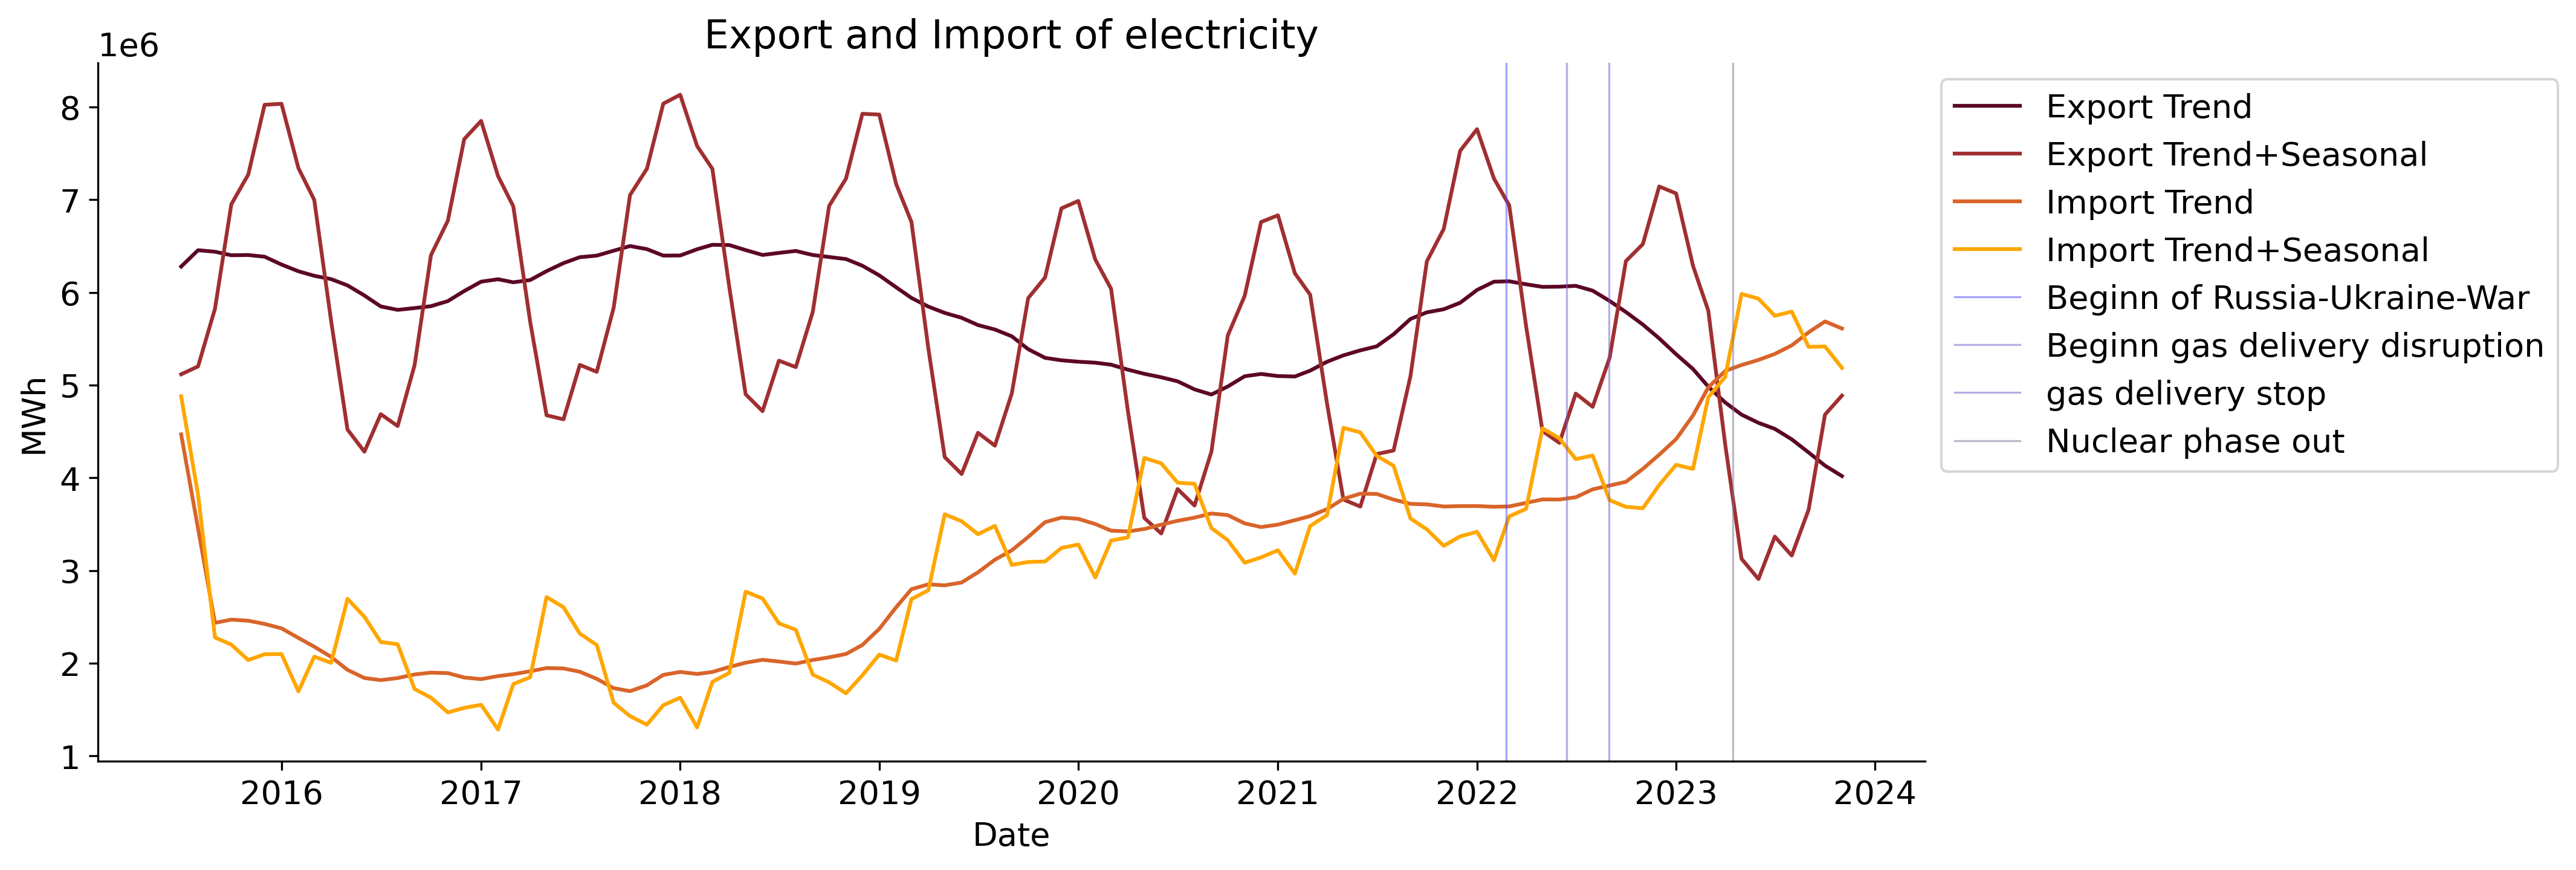

In [28]:
plt.figure(figsize=(13,5), dpi = 300)
plt.plot(Export_monthly['Trend'], color= '#5c0728', label='Export Trend')
plt.plot(Export_monthly['Trend+Seasonal'],color='#a02f31', label='Export Trend+Seasonal')
plt.plot(Import_monthly['Trend'], color= '#d9642a', label='Import Trend')
plt.plot(Import_monthly['Trend+Seasonal'],color='#ffa600', label='Import Trend+Seasonal')




plt.axvline(x=dt.datetime(2022,2,24),color = '#4a48ff', alpha = .5, linewidth = .8,  label = 'Beginn of Russia-Ukraine-War')
plt.axvline(x=dt.datetime(2022,6,14),color = '#705ec9', alpha = .5, linewidth = .8,  label = 'Beginn gas delivery disruption')
plt.axvline(x=dt.datetime(2022,8,31),color = '#705ec9', alpha = .5, linewidth = .8,  label = 'gas delivery stop')
plt.axvline(x=dt.datetime(2023,4,15),color = '#7b7294', alpha = .5, linewidth = .8,  label = 'Nuclear phase out')


plt.title('Export and Import of electricity')
plt.ylabel('MWh')
plt.xlabel('Date')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

We can see here that over the analysis period the export-import balance changes from an exporter to an importer. This is mainly due to the increase in renewables and the simultaneous loss of base load supply. This base load is now imported from neighboring countries when required.

In [29]:
Export_Import_weekly = decomposition_df(Export_Import,'Export_Import_sum','W')

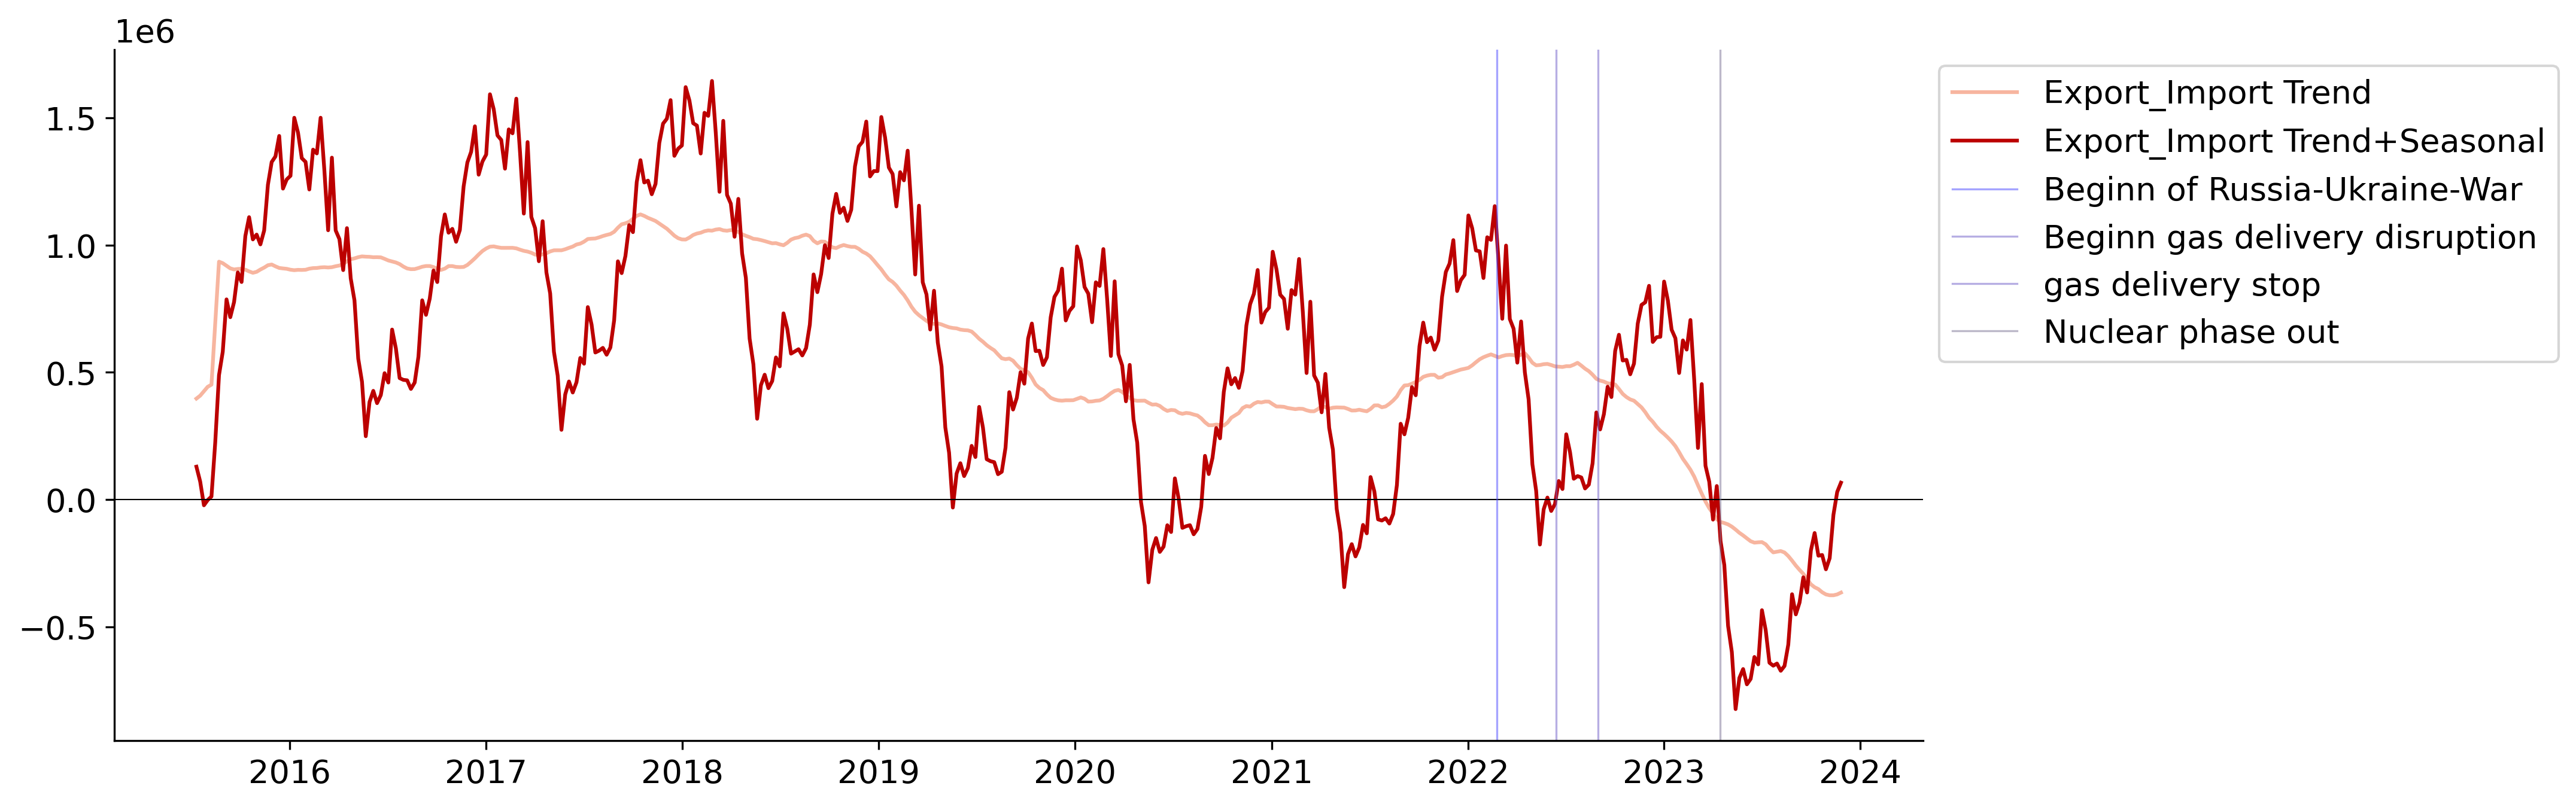

In [30]:
plt.figure(figsize=(13,5), dpi = 300)
plt.plot(Export_Import_weekly['Trend'], color= '#f7b59f', label='Export_Import Trend')
plt.plot(Export_Import_weekly['Trend+Seasonal'],color='#bc0000', label='Export_Import Trend+Seasonal')

plt.axhline(y=0,color = '#000000', linewidth = 0.5)


plt.axvline(x=dt.datetime(2022,2,24),color = '#4a48ff', alpha = .5, linewidth = .8,  label = 'Beginn of Russia-Ukraine-War')
plt.axvline(x=dt.datetime(2022,6,14),color = '#705ec9', alpha = .5, linewidth = .8,  label = 'Beginn gas delivery disruption')
plt.axvline(x=dt.datetime(2022,8,31),color = '#705ec9', alpha = .5, linewidth = .8,  label = 'gas delivery stop')
plt.axvline(x=dt.datetime(2023,4,15),color = '#7b7294', alpha = .5, linewidth = .8,  label = 'Nuclear phase out')
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

Particularly noteworthy is the final change between exporter and importer with the nuclear phase-out in April 2023. The decline in the export surplus can also be explained by the gradual shutdown of nuclear power plants. Here, too, we can see that the trend was halted during the Corona crisis, but not reversed. The Federal Republic of Germany has decided to use weather-dependent power generation without a base load alternative to generate electricity in the world's 4th largest economy. This strategy was based on gas, French nuclear power and Polish coal. The gas pillar finally collapsed with the war in 2022 and the explosion of the Nord Stream pipeline.

In [31]:
Consumption_hourly = decomposition_df(Consumption,'Total_sum','h')
Generation_hourly = decomposition_df(Generation, 'Generation_sum','h')

In [32]:
Consumption_hourly_vis = date_feature_creator(Consumption_hourly)
Generation_hourly_vis = date_feature_creator(Generation_hourly)

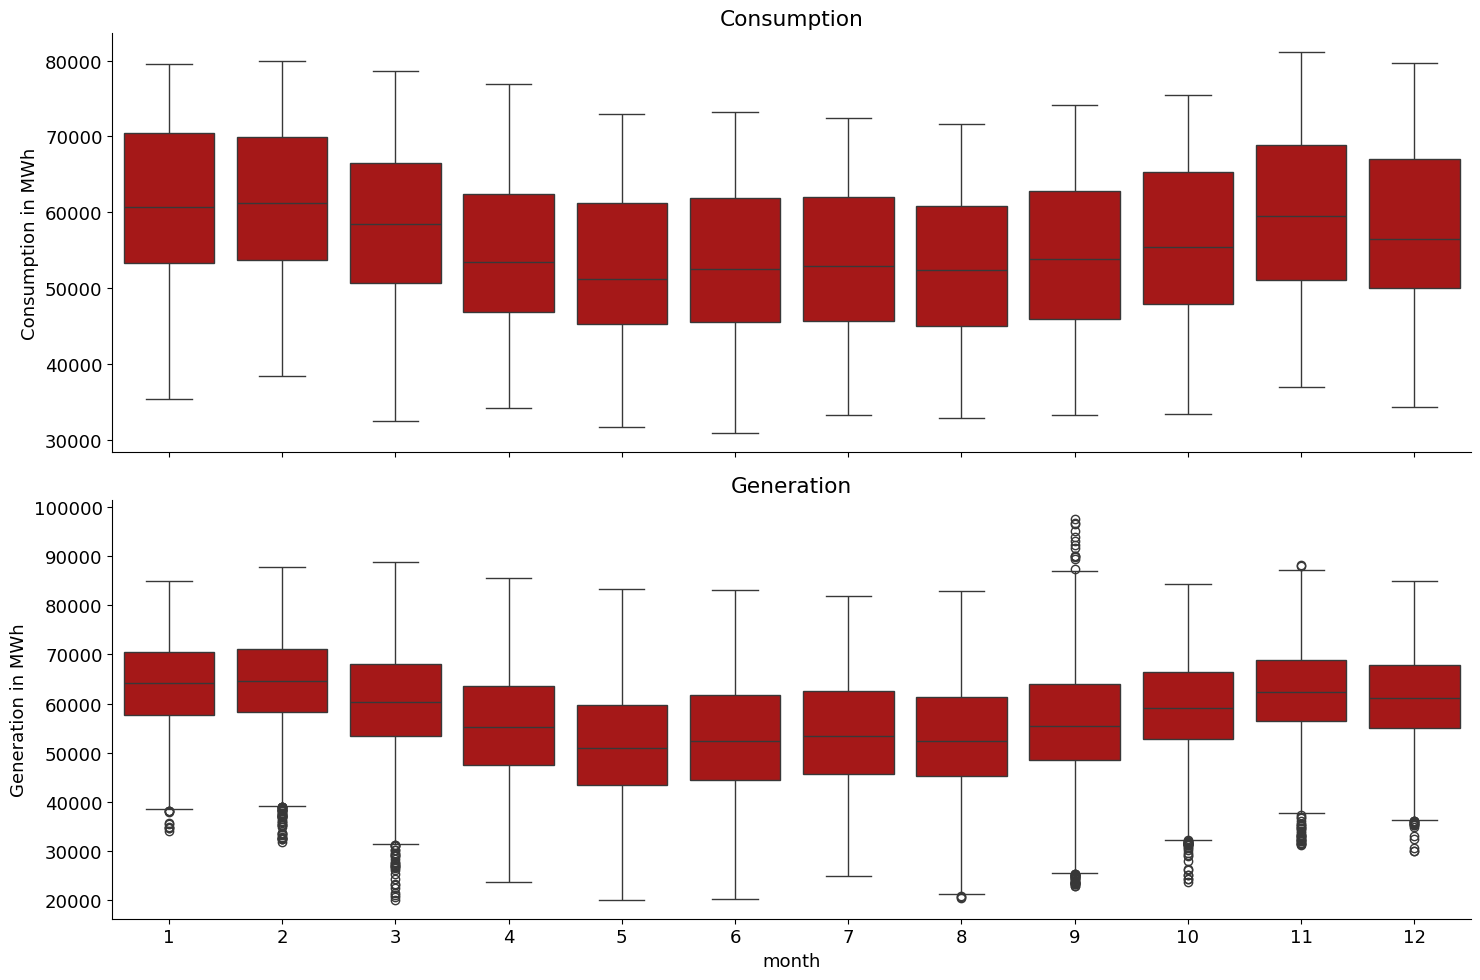

In [37]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

sns.boxplot(data=Consumption_hourly_vis, x='month', y='Total_sum', color='#bc0000', ax=axes[0])
axes[0].set_title('Consumption')

sns.boxplot(data=Generation_hourly_vis, x='month', y='Generation_sum', color='#bc0000', ax=axes[1])
axes[1].set_title('Generation')


axes[0].set_ylabel('Consumption in MWh')
axes[1].set_ylabel('Generation in MWh')
plt.tight_layout()
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)
plt.show()

Here we see the increased electricity demand and generation in the cold season. This is typical for Central Europe, as air conditioning is not widespread.

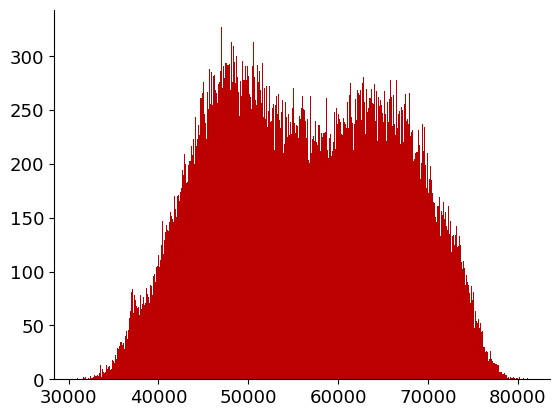

In [34]:
plt.figure()

plt.hist(Consumption_hourly_vis['Total_sum'], bins = 500, color = '#bc0000')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

In this histogram we see the clear duck curve of electricity demand, with the two peaks in the morning and evening and the corresponding accumulation of these two demands over the year

## Export <a class="anchor" id="heading-3"></a>

Since we have introduced some auxiliary columns and totals, the files will be exported again.

In [35]:
Prices.to_csv('../data/Prices_eda.csv', index= True)
Export_Import.to_csv('../data/Export_Import_eda.csv', index= True)
Consumption.to_csv('../data/Consumption_eda.csv', index= True)
Generation.to_csv('../data/Generation_eda.csv', index= True)

___
#### Conclusion / Next Steps

In the further course, the data is prepared for modeling and a solution approach is explained.     
Please continue with [03-splitting and pre-processing](03-splitting-and-pre-processing.ipynb)

___